## SETUP DO DIRETORIO DO GOOGLE DRIVE

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


# **IMPORT E LOAD DE DADOS**

In [18]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('ggplot')
# PROCESSAMENTO
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# MODELOS
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

import seaborn as sns
import scipy

# PREPROCESSAMENTO E METRICAS
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *

# EXPORTAÇÃO
# Lib para exportar scalers
# https://scikit-learn.org/stable/modules/model_persistence.html
from joblib import dump, load

# Lib para exportar numpy ou arrays
# https://www.christopherlovell.co.uk/blog/2016/04/27/h5py-intro.html
import h5py

In [19]:
infile = "https://raw.githubusercontent.com/ddlandim/monografy-ann-demand-prediction/master/experimentos_monografia/input/Todos.csv"

dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')

df = pd.read_csv(infile, parse_dates=['DATA'], date_parser=dateparse,index_col='DATA')

df

,SEMESTRE_1,SEMESTRE_2,SEGUNDA,TERCA,QUARTA,QUINTA,SEXTA,DISTANCIA_DIA_ANTERIOR,DISTANCIA_DIA_POSTERIOR,PERC_CONCLUSAO_SEM,PERC_CONCLUSAO_MES,PRESSAO_ATMOSFERICA,TEMPERATURA,UMIDADE,VENTO,VENDAS_ALMOCO,VENDAS_ALMOCO_1,VENDAS_ALMOCO_2,VENDAS_ALMOCO_3,VENDAS_ALMOCO_4,VENDAS_ALMOCO_5,ENTR_ALMOCO,ENTR_ALMOCO_1,ENTR_ALMOCO_2,ENTR_ALMOCO_3,ENTR_ALMOCO_4,ENTR_ALMOCO_5,ENTR_JANTAR,ENTR_JANTAR_1,ENTR_JANTAR_2,ENTR_JANTAR_3,ENTR_JANTAR_4,ENTR_JANTAR_5
DATA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-04-12,1,0,0,0,1,0,0,1,1,35.97,40.00,950.7,22.0,84,0.9,14,14,14,14,14,14,14,14,14,14,14,14,0,0,0,0,0,0
2017-04-13,1,0,0,0,0,1,0,1,4,36.69,43.33,953.3,21.0,75,2.2,22,14,14,14,14,14,22,14,14,14,14,14,0,0,0,0,0,0
2017-04-17,1,0,1,0,0,0,0,4,1,39.57,56.67,950.4,22.3,79,0.3,10,22,14,14,14,14,10,22,14,14,14,14,0,0,0,0,0,0
2017-04-18,1,0,0,1,0,0,0,1,1,40.29,60.00,953.9,19.3,77,1.2,27,10,22,14,14,14,26,10,22,14,14,14,0,0,0,0,0,0
2017-04-19,1,0,0,0,1,0,0,1,1,41.01,63.33,954.5,18.4,75,2.1,18,27,10,22,14,14,17,26,10,22,14,14,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-10,0,1,0,1,0,0,0,1,1,95.52,32.26,947.8,22.9,81,1.8,75,157,116,291,283,414,61,122,112,170,257,292,19,69,39,132,111,163
2019-12-11,0,1,0,0,1,0,0,1,1,96.27,35.48,946.6,22.9,82,1.6,45,75,157,116,291,283,49,61,122,112,170,257,9,19,69,39,132,111
2019-12-12,0,1,0,0,0,1,0,1,1,97.01,38.71,945.2,22.2,75,1.0,43,45,75,157,116,291,54,49,61,122,112,170,8,9,19,69,39,132


In [20]:
# Testando lag temporal
df['ENTR_ALMOCO_1'][50] == df['ENTR_ALMOCO_2'][51]

True

#### **FUNÇÕES AUXILIARES**

In [21]:
# plota serie
def plot_serie(serie, size=(12,4), title='Plot'):
    plt.figure(figsize=size)
    plt.title(title)
    plt.plot(serie)
    plt.show()

In [22]:
# pega coluna dataframe['coluna_y'] e usa como y
# todas as outras colunas usa como x 
def to_supervised_numpy(dataframe, coluna_y):
    X = dataframe.loc[:, dataframe.columns != coluna_y].values # instantes de tempo passado (lags)
    Y = dataframe[coluna_y].values # valor atual para prever
    return np.array(X), np.array(Y)

In [23]:
def plot_history(history, start_epoch=0):
    start_epoch = 10
    plt.figure(figsize=(10,4))
    plt.title('História Treino')
    plt.plot(history.history['loss'][start_epoch:], label='Train Loss')
    plt.plot(history.history['val_loss'][start_epoch:], label='Validation Loss')
    plt.legend()

In [24]:
df_models_metrics = pd.DataFrame()
df_models_metrics['parameters'] =  ['TOTAL_PROJETADAS','TOTAL_CONSUMIDAS','TOTAL_SUBPROJETADAS','TOTAL_SUPERPROJETADAS','ERRO_ABS_MEDIO','ERRO_ABS_PER_MEDIO']

In [25]:
def pe (row,true,predicted): # array of % error
    true = row[true]
    predicted = int(row[predicted])
    error = predicted - true
    if true == 0:
        pe = 0
    else:
        pe = abs(error/true)
    return pe,error

def mape (_df,x,y): # mean of array of % error
    df = pd.DataFrame()
    df = _df
    arr_pe = [0,0]
    arr_pe = df.apply(lambda row: pe(row,x,y), axis=1)
    return np.mean(arr_pe[0])*100 , arr_pe[1]

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+0.001))) * 100

def avaliacao_predicoes (_df,true,pred,df_models_metrics):
    df = pd.DataFrame()
    df = _df
    arr_true = df[true]
    arr_pred = df[pred]
    m_r, m_p = scipy.stats.pearsonr(arr_true, arr_pred)
    print("CORRELAÇÃO (r): " + str(m_r) + " Pi (p) :" + str(m_p))
    sns.regplot(x=arr_true,y=arr_pred,data=df)
    rmse = mean_squared_error(arr_true, arr_pred, squared=False)
    print("RMSE = " + str(rmse))
    arr_e = arr_pred - arr_true
    m_mae = np.median(np.abs(arr_e))
    m_mape = mean_absolute_percentage_error(arr_true,arr_pred)
    subpredictions = sum(i for i in arr_e if i < 0)
    superpredictions = sum(i for i in arr_e if i >= 0)
    print("TOTAL DE REFEIÇÕES PROJETADAS = " + str(len(arr_pred)) + " : " + str(sum(arr_pred)))
    print("TOTAL DE REFEIÇÕES CONSUMIDAS = " + str(len(arr_true)) + " : " + str(sum(arr_true)))
    print("TOTAL DE REFEIÇÕES SUB PROJETADAS = " + str(subpredictions))
    print("TOTAL DE REFEIÇÕES SUPER PROJETADAS = " + str(superpredictions))
    print("ERRO ABSOLUTO MEDIANO = " + str(m_mae))
    print("ERRO ABSOLUTO PERCENTUAL MEDIO = " + str(m_mape)+"%")
    plt.figure(figsize=(30,5))
    df[true].plot( linewidth=1.5, color='red', label = true)
    df[pred].plot( linewidth=2.5, color='blue', label = pred)
    plt.legend()
    plt.xlabel("Index", labelpad=15)
    plt.show()
    #['TOTAL_PROJETADAS','TOTAL_CONSUMIDAS','TOTAL_SUBPROJETADAS','TOTAL_SUPERPROJETADAS','ERRO_ABS_MEDIO','ERRO_ABS_PER_MEDIO']
    #df_models_metrics.drop(columns=[pred])
    df_models_metrics[pred] = [sum(arr_pred),sum(arr_true),subpredictions,superpredictions,m_mae,m_mape]
    return m_r,m_p,rmse,m_mape,subpredictions,superpredictions

In [26]:
def ru_pred_almoco (row,factor):
    true_5days_ago = row['ENTR_ALMOCO_5']
    predicted = int(true_5days_ago + (true_5days_ago*factor))
    return predicted

def ru_pred_jantar (row,factor):
    true_5days_ago = row['ENTR_JANTAR_5']
    predicted = int(true_5days_ago + (true_5days_ago*factor))
    return predicted

# **case1_** SPLIT TREINO / TESTE

In [27]:
prefix = 'case1_'
test_start = '2019-01-01'
validation_start = '2018-01-01'
validation_semester = 'SEMESTRE_1'

df_test = df.loc[ test_start : ]

df_split =  df.loc[ validation_start : test_start ]

df_train1 = df.loc[ : validation_start ]
df_train2 = df_split.loc[  df_split[ validation_semester ] == 0 ]
df_train = pd.concat([df_train1,df_train2])

df_val = df_split.loc[  df_split[ validation_semester ] == 1 ]

df_len = len(df)
df_split_len = len(df_split)
df_test_len = len(df_test)
df_train1_len = len(df_train1)
df_train2_len = len(df_train2)
df_train_len = len(df_train)
df_val_len = len(df_val)

assert_dfs_splits = df_len == (df_train_len + df_val_len + df_test_len)

print('Tamanho do conjunto de dados = ' + str(df_len))

print('Tamanho do conjunto de treino até o conjunto de validação = ' + str(df_train1_len) + " [ : " + validation_start + " ]")

print('Split = ' + str(df_split_len) + " [" + validation_start + " : " + test_start + " ]")

print('Tamanho da 2a parte do conjunto de treino entre o fim do conjunto de validação e o inicio do conjunto de teste = ' + str(df_train2_len) +  " [" + validation_start + " : " + test_start + '] where ' + validation_semester + " == False")
print('Tamanho do conjunto total de treino = ' + str(df_train_len))
print('Tamanho do conjunto de validação = ' + str(df_val_len) +  " [ " + validation_start + " : " + test_start + ' ] where ' + validation_semester + " == True")
print('Tamanho do conjuto de teste = ' + str(df_test_len))
if assert_dfs_splits:
  print("Divisão realizada com sucesso, a soma dos conjuntos de treino,validação e teste corresponderam ao tamanho do dataset original")
else:
  print("error in split, check the size diff above")
  print(df_train_len+df_test_len+df_test_len - df_len)

Tamanho do conjunto de dados = 514
Tamanho do conjunto de treino até o conjunto de validação = 148 [ : 2018-01-01 ]
Split = 184 [2018-01-01 : 2019-01-01 ]
Tamanho da 2a parte do conjunto de treino entre o fim do conjunto de validação e o inicio do conjunto de teste = 95 [2018-01-01 : 2019-01-01] where SEMESTRE_1 == False
Tamanho do conjunto total de treino = 243
Tamanho do conjunto de validação = 89 [ 2018-01-01 : 2019-01-01 ] where SEMESTRE_1 == True
Tamanho do conjuto de teste = 182
Divisão realizada com sucesso, a soma dos conjuntos de treino,validação e teste corresponderam ao tamanho do dataset original


In [28]:
df_test = df_test.loc[  df_test[ validation_semester ] == 1 ]
df_test

,SEMESTRE_1,SEMESTRE_2,SEGUNDA,TERCA,QUARTA,QUINTA,SEXTA,DISTANCIA_DIA_ANTERIOR,DISTANCIA_DIA_POSTERIOR,PERC_CONCLUSAO_SEM,PERC_CONCLUSAO_MES,PRESSAO_ATMOSFERICA,TEMPERATURA,UMIDADE,VENTO,VENDAS_ALMOCO,VENDAS_ALMOCO_1,VENDAS_ALMOCO_2,VENDAS_ALMOCO_3,VENDAS_ALMOCO_4,VENDAS_ALMOCO_5,ENTR_ALMOCO,ENTR_ALMOCO_1,ENTR_ALMOCO_2,ENTR_ALMOCO_3,ENTR_ALMOCO_4,ENTR_ALMOCO_5,ENTR_JANTAR,ENTR_JANTAR_1,ENTR_JANTAR_2,ENTR_JANTAR_3,ENTR_JANTAR_4,ENTR_JANTAR_5
DATA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-20,1,0,0,0,1,0,0,61,1,0.73,71.43,947.9,23.7,78,0.5,966,10,40,58,95,111,441,14,35,44,88,77,246,0,17,14,27,50
2019-02-21,1,0,0,0,0,1,0,1,1,1.46,75.00,949.8,22.9,84,1.5,779,966,10,40,58,95,458,441,14,35,44,88,279,246,0,17,14,27
2019-02-22,1,0,0,0,0,0,1,1,3,2.19,78.57,951.6,25.5,77,2.7,314,779,966,10,40,58,275,458,441,14,35,44,61,279,246,0,17,14
2019-02-25,1,0,1,0,0,0,0,3,1,4.38,89.29,946.4,27.6,71,0.6,807,314,779,966,10,40,455,275,458,441,14,35,196,61,279,246,0,17
2019-02-26,1,0,0,1,0,0,0,1,1,5.11,92.86,949.8,21.4,87,1.6,615,807,314,779,966,10,401,455,275,458,441,14,233,196,61,279,246,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01,1,0,1,0,0,0,0,3,1,96.35,3.23,952.2,18.8,74,0.6,80,111,376,348,442,632,94,196,259,266,438,385,23,20,120,129,146,157
2019-07-02,1,0,0,1,0,0,0,1,1,97.08,6.45,947.6,17.3,78,1.0,113,80,111,376,348,442,116,94,196,259,266,438,35,23,20,120,129,146
2019-07-03,1,0,0,0,1,0,0,1,1,97.81,9.68,946.0,16.9,82,0.5,62,113,80,111,376,348,80,116,94,196,259,266,43,35,23,20,120,129


In [29]:
#%% md

# TECNICA DO R.U, ANÁLISE DA 5A ÚLTIMA VENDA - CONJUNTO DE TESTE

#%% PREVISÃO DO R.U - CALCULO DO ALMOÇO

df_models_metrics2 = pd.DataFrame()

factor = 0.3
df_test['RU_ALMOCO_PRED'] = df_test.apply(lambda row: ru_pred_almoco(row,factor), axis=1)

#%% PREVISÃO DO R.U - CALCULO DO JANTAR

factor = 0.3
df_test['RU_JANTAR_PRED'] = df_test.apply(lambda row: ru_pred_jantar(row,factor), axis=1)

#%% PREVISÃO DO R.U - AVALIAÇÃO ALMOÇO

ru_almoco_metrics = []
ru_almoco_metrics = avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'RU_ALMOCO_PRED',df_models_metrics2)

#%% PREVISÃO DO R.U - AVALIAÇÃO JANTAR

ru_jantar_metrics = []
ru_jantar_metrics = avaliacao_predicoes(df_test,'ENTR_JANTAR', 'RU_JANTAR_PRED',df_models_metrics2)

#%% md

# ANALISANDO AS FEATURES DO DATASET

#%% md

## ANÁLISES DAS FEATURES CATEGORICAS

#%%

print('FEATURES CATEGORICAS, 0 = AUSENTE, 1 = PRESENTE')
plt.figure(figsize=(4,3))
sns.violinplot(x='SEGUNDA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))
sns.violinplot(x='TERCA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))
sns.violinplot(x='QUARTA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))
sns.violinplot(x='QUINTA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))
sns.violinplot(x='SEXTA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))


#%% md

## ANÁLISES DAS FEATURES QUATITATIVAS

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS

print('COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 5 DIAS ANTERIORES')
VENDAS_ALMOCO_5_metrics = []
VENDAS_ALMOCO_5_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'VENDAS_ALMOCO_5',df_models_metrics2)

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS

print('COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 1 DIA ANTERIOR')
VENDAS_ALMOCO_1_metrics = []
VENDAS_ALMOCO_1_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'VENDAS_ALMOCO_1',df_models_metrics2)

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS

print('COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 2 DIAS ANTERIORES')
VENDAS_ALMOCO_2_metrics = []
VENDAS_ALMOCO_2_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'VENDAS_ALMOCO_2',df_models_metrics2)

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO AO AVANÇO DO SEMESTRE

print('COMPORTAMENTO DE CONSUMO EM RELAÇÃO AO AVANÇO DO SEMESTRE')
PERC_CONCLUSAO_SEM_metrics = []
PERC_CONCLUSAO_SEM_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'PERC_CONCLUSAO_SEM',df_models_metrics2)

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO AO AVANÇO DO MÊS

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO AO AVANÇO DO MÊS')
PERC_CONCLUSAO_MES_metrics = []
PERC_CONCLUSAO_MES_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'PERC_CONCLUSAO_MES',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À DISTANCIA EM DIAS PARA 1 DIA LETIVO ANTERIOR

ENTR_ALMOCO_metrics = []
ENTR_ALMOCO_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'DISTANCIA_DIA_ANTERIOR',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À DISTANCIA EM DIAS PARA 1 DIA LETIVO ANTERIOR

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À DISTANCIA EM DIAS PARA 1 DIA LETIVO POSTERIOR')
DISTANCIA_DIA_POSTERIOR = []
DISTANCIA_DIA_POSTERIOR = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'DISTANCIA_DIA_POSTERIOR',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À JANTA (CONSUMIDA) DE 1 DIA LETIVO ANTERIOR

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À JANTA (CONSUMIDA) DE 1 DIA LETIVO ANTERIOR')
ENTR_JANTAR_1_metrics = []
ENTR_JANTAR_1_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'ENTR_JANTAR_1',df_models_metrics2)


#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À PRESSAO ATMOSFÉRICA

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À PRESSAO ATMOSFÉRICA')
PRESSAO_ATMOSFERICA_metrics = []
PRESSAO_ATMOSFERICA_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'PRESSAO_ATMOSFERICA',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À TEMPERATURA

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À TEMPERATURA')
TEMPERATURA_metrics = []
TEMPERATURA_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'TEMPERATURA',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO AO VENTO

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO AO VENTO')
VENTO_metrics = []
VENTO_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'VENTO',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À UMIDADE

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À UMIDADE')
UMIDADE_metrics = []
UMIDADE_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'UMIDADE',df_models_metrics2)

Output hidden; open in https://colab.research.google.com to view.

#### **FORMATANDO FEATURES TEMPORAIS PARA SHAPE COMPATÍVEL COM REDES RECORRENTES**
shape = (num_samples,   num_lags_passados,   num_features)

In [30]:
# pegando features temporais
# IMPORTANTE ESTAR EM ORDEM !! PRIMEIRO ELEMENTO = Y E OS DEMAIS = X0, X1, ...
feature_0 = ['ENTR_ALMOCO', 'ENTR_ALMOCO_1', 'ENTR_ALMOCO_2','ENTR_ALMOCO_3', 'ENTR_ALMOCO_4', 'ENTR_ALMOCO_5',]
feature_1 = ['VENDAS_ALMOCO','VENDAS_ALMOCO_1','VENDAS_ALMOCO_2','VENDAS_ALMOCO_3','VENDAS_ALMOCO_4','VENDAS_ALMOCO_5']
feature_2 = ['ENTR_JANTAR','ENTR_JANTAR_1', 'ENTR_JANTAR_2', 'ENTR_JANTAR_3', 'ENTR_JANTAR_4','ENTR_JANTAR_5']
features_temporais = [feature_0, feature_1, feature_2]
##################################################
feature_to_predict = 0 # ENTR_ALMOCO, feature 0 que será o valor da saída do modelo (trocar se quiser)
##################################################
num_temporais = len(features_temporais) # 3 séries temporais


train_x, train_y = [], []
val_x, val_y = [], []
test_x, test_y = [], []
# serapando em dfs com somente uma feature
for feature_cols in features_temporais:
    # train
    x, y = to_supervised_numpy(df_train[feature_cols], feature_cols[0]) # feature[0] = ENTR_ALMOCO = y!!! IMPORTANTE  
    train_x.append(x); train_y.append(y)
    # validacao
    x, y = to_supervised_numpy(df_val[feature_cols], feature_cols[0]) # feature[0] = VENDAS_ALMOCO = y!!! IMPORTANTE  
    val_x.append(x); val_y.append(y)
    # test
    x, y = to_supervised_numpy(df_test[feature_cols], feature_cols[0]) # feature[0] = ENTR_JANTAR = y !!! IMPORTANTE  
    test_x.append(x); test_y.append(y)

    
# transforma em numpy array
train_x = np.array(train_x);  train_y = np.array(train_y); 
val_x = np.array(val_x);  val_y = np.array(val_y); 
test_x = np.array(test_x);  test_y = np.array(test_y); 
#
print('shape treino:', val_x.shape, val_y.shape)
print('shape validacao:', train_x.shape, train_y.shape)
print('shape teste:', test_x.shape, test_y.shape)

shape treino: (3, 89, 5) (3, 89)
shape validacao: (3, 243, 5) (3, 243)
shape teste: (3, 88, 5) (3, 88)


#### **TRATAMENTO DE OUTLIERS NAS FEATURES TEMPORAIS**
verifica se é distante da média

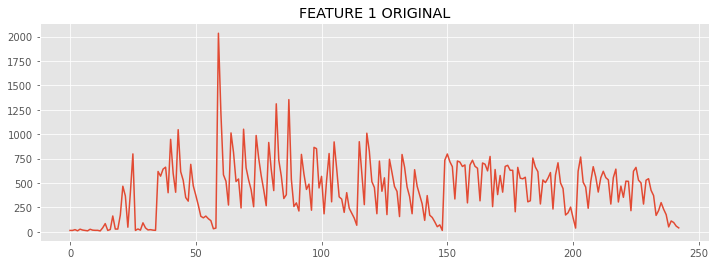

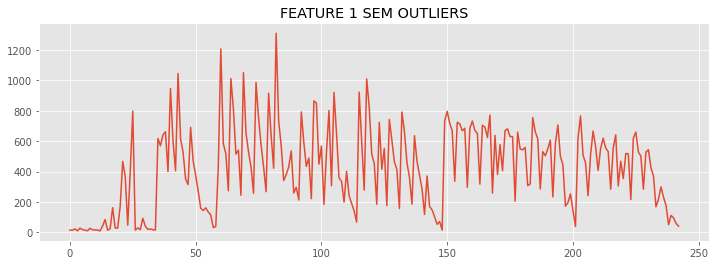

10 outliers  aredondados para a media


In [31]:
TRATAR_OUTLIERS_NAS_FEATURES_TEMPORAIS = True
tolerancia_sigma = 3
num_outliers = 0
if TRATAR_OUTLIERS_NAS_FEATURES_TEMPORAIS:
    plot_serie(train_x[1, :, 0], title='FEATURE 1 ORIGINAL')
    num_outliers = 0
    for feature_i in range(num_temporais):
        desvio_padrao = np.std(train_x[feature_i, :, 0])
        media = np.mean(train_x[feature_i, :, 0])
        for lag_i in range(train_x.shape[2]):
            for element_i in range(train_x.shape[1]):
                valor = train_x[feature_i, element_i, lag_i]
                if np.abs(valor - media) >= tolerancia_sigma*desvio_padrao:
                    train_x[feature_i, element_i, lag_i] = media
                    num_outliers += 1
    
    plot_serie(train_x[1, :, 0], title='FEATURE 1 SEM OUTLIERS')
    print(num_outliers, 'outliers  aredondados para a media')

#### **ESCALONANDO FEATURES TEMPORAIS (MINMAX SCALER)**

Criados 3 scalers para as features temporais
(3, 5, 243, 1) (3, 243, 1)
(3, 5, 89, 1) (3, 89, 1)
(3, 5, 88, 1) (3, 88, 1)


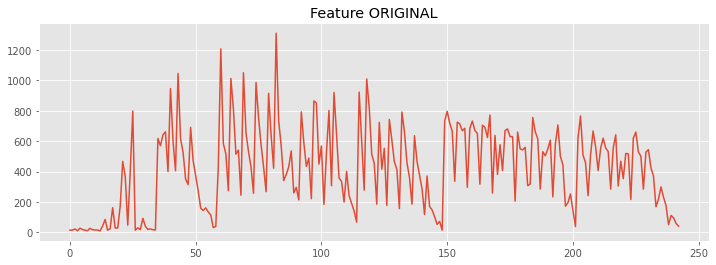

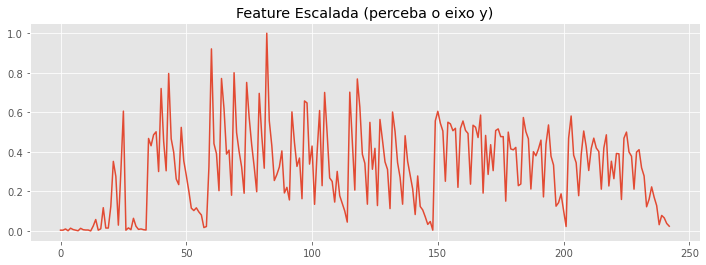

In [32]:
#
# o correto seria escalonar antes de dividir em lags mas como ja foi dividido sera preciso
# fazer dessa forma não muito otimizada
# escalando features
scalers = [MinMaxScaler([0,1]) for i in range(num_temporais)] # Um scaler para cada feature TEMPORAL
print('Criados', len(scalers),'scalers para as features temporais')

# nao é a maneira mais eficiente, mas é a mais facil de implementar nessas condicoes

def treina_scalers(train_x):
    for i in range(len(train_x)): # pra cada feature
        feature_x = train_x[i]
        scalers[i].fit(feature_x[:, 0].reshape(-1,1)) # poderia usar qualquer coluna(lag), usando a primeira aqui
#     
def scala_features(data_x, data_y):
    scaled_data_x, scaled_data_y = [], []
    for feature_i in range(len(data_x)): # pra cada feature
        x = data_x[feature_i]; y = data_y[feature_i].reshape(-1, 1)
        scaled_x = []
        # pra cada lag, aplicar transform depois de ter 'treinado' o scaler(calculado parametros media etc)
        for lag in range(x.shape[1]): # x.shape[1] = numero de lags (nesse caso 5)
            lag_scaled = scalers[feature_i].transform(x[:, lag].reshape(-1,1)) # lag atual, ENTR_JANTAR_'lag' por exemplo
            scaled_x.append(lag_scaled) # adiciona cada lag no vetor de retorno, lag_1, lag_2 .. lag_5
        # scaled_x = vetor de lags para a feature do for mais externo, feature de indice feature_i
        scaled_data_x.append(np.array(scaled_x))
        scaled_data_y.append(scalers[feature_i].transform(y))
    return np.array(scaled_data_x), np.array(scaled_data_y)


# treina
treina_scalers(train_x) # treina os scalers para depois usar
# fit transform
scaled_train_x, scaled_train_y = scala_features(train_x, train_y)
scaled_val_x, scaled_val_y = scala_features(val_x, val_y)
scaled_test_x, scaled_test_y = scala_features(test_x, test_y)


# (num_features, num_lags, num_samples, 1) e (num_features, num_samples, 1)
print(scaled_train_x.shape, scaled_train_y.shape)
print(scaled_val_x.shape, scaled_val_y.shape)
print(scaled_test_x.shape, scaled_test_y.shape)

#
feature_para_ver = 1
plot_serie(train_x[feature_para_ver, :, 0], title='Feature ORIGINAL')
plot_serie(scaled_train_x[feature_para_ver, 0, :, 0], title='Feature Escalada (perceba o eixo y)')


#### **TRANSPONDO MATRIZES (SÓ UMA CONVENÇÃO, NÃO ALTERA NADA)**
Transpõe matrizes para ordem correta dos eixos
* Shape de Antes: **data_X:(num_features, num_lags, num_instancias, 1) data_Y:(num_features, num_instancias, 1)**
* Shape de Depois: **data_X:(num_instancias, num_lags, num_features) data_Y:(num_instancias, num_features)**

In [33]:
def transpose_to_rnn(data_x, data_y): # faz a transposição (necessario devido ao problema citado acima)
    data_x = data_x.transpose(2, 1, 0, 3)
    data_y = data_y.transpose(1, 0, 2)
    data_x = np.squeeze(data_x) # remove ultima dimensão desnecessaria()
    data_y = np.squeeze(data_y) # remove ultima dimensão desnecessaria()

    return data_x, data_y
# sobreescreve matrizes , portanto executar uma única vez
scaled_train_x, scaled_train_y = transpose_to_rnn(scaled_train_x, scaled_train_y)
scaled_val_x, scaled_val_y = transpose_to_rnn(scaled_val_x, scaled_val_y)
scaled_test_x, scaled_test_y = transpose_to_rnn(scaled_test_x, scaled_test_y)
#
print(scaled_train_x.shape, scaled_train_y.shape)
print(scaled_val_x.shape, scaled_val_y.shape)
print(scaled_test_x.shape, scaled_test_y.shape)
#

(243, 5, 3) (243, 3)
(89, 5, 3) (89, 3)
(88, 5, 3) (88, 3)


#### **REMOVENDO Y QUE NÃO QUEREMOS PREVER DAS FEATURES TEMPORAIS(JANTA POR EXEMPLO)**


In [34]:
# os vetores train_y, val_y e test_y possuem o y para todas as features
# porém queremos prever somente uma delas (saida da rede pode ser as tres caso quisermos)
# portanto vamos retirar as outras dos vetores y

# dados originais
train_y = train_y[feature_to_predict,:]
val_y = val_y[feature_to_predict,:]
test_y = test_y[feature_to_predict,:]
# dados escalados
scaled_train_y = scaled_train_y[:, feature_to_predict]
scaled_val_y = scaled_val_y[:, feature_to_predict]
scaled_test_y = scaled_test_y[:, feature_to_predict]
print(scaled_train_y.shape)
print(scaled_val_y.shape)
print(scaled_test_y.shape)

(243,)
(89,)
(88,)


#### **SEPARA FEATURES NÃO TEMPORAIS (ONE HOT E NUMERICAS)**


In [35]:
# features one hot
features_categoricas = ['SEMESTRE_1', 'SEMESTRE_2']
# divide df completo
train_x_cat = df_train[features_categoricas].values
val_x_cat = df_val[features_categoricas].values
test_x_cat = df_test[features_categoricas].values
print('features categoricas one_hot: ',train_x_cat.shape, val_x_cat.shape, test_x_cat.shape)




#features numericas pontuais
features_numericas_pontuais = ['DISTANCIA_DIA_ANTERIOR', 'DISTANCIA_DIA_POSTERIOR',
       'PERC_CONCLUSAO_SEM', 'PERC_CONCLUSAO_MES', 'PRESSAO_ATMOSFERICA',
       'TEMPERATURA', 'UMIDADE', 'VENTO']
# divide df completo
train_x_numpont = df_train[features_numericas_pontuais].values
val_x_numpont = df_val[features_numericas_pontuais].values
test_x_numpont = df_test[features_numericas_pontuais].values
print('features numericas pontuais:', train_x_numpont.shape, val_x_numpont.shape, test_x_numpont.shape)

features categoricas one_hot:  (243, 2) (89, 2) (88, 2)
features numericas pontuais: (243, 8) (89, 8) (88, 8)


#### **ESCALA FEATURES NÃO TEMPORAIS E COMPACTA EM UM UNICO VETOR**


In [36]:
# scaler das features numericas não temporais (temperatura, umidade etc) 
# nesse caso pode usar um unico scaler (ele cria diferentes estatisticas para cada feature)
scaler_numpont = MinMaxScaler([0,1]).fit(train_x_numpont)
train_x_numpont = scaler_numpont.transform(train_x_numpont)
val_x_numpont = scaler_numpont.transform(val_x_numpont)
test_x_numpont = scaler_numpont.transform(test_x_numpont)

# concatena tudo pra alimentar parte densa do modelo
train_x_dense = np.hstack([train_x_numpont, train_x_cat])
val_x_dense = np.hstack([val_x_numpont, val_x_cat])
test_x_dense = np.hstack([test_x_numpont, test_x_cat])

print('treino', train_x_dense.shape)
print('validacao', val_x_dense.shape)
print('teste', test_x_dense.shape)

treino (243, 10)
validacao (89, 10)
teste (88, 10)


In [37]:
# RESULTADO 
print(scaled_train_x.shape, ' e ', train_x_dense.shape)

(243, 5, 3)  e  (243, 10)


# **Definição e Treino de Modelos**

## EXPLORANDO O PROBLEMA (RODAR PRIMEIROS TREINOS)
 CRIAR UMA MLP PADRÃO (1 CAMADA 1 SAÍDA), CHEGANDO NELA TODAS AS FEATURES ESCALADAS
 DEIXA-LA PREPARADA PARA SER USADA PARA PREVISÕES ASSIM COMO AS OUTRAS
 ESTA MLP SERÁ USADA PARA EXPLORAR O DOMÍNIO DO PROBLEMA E REALIZAR PRIMEIROS TREINOS. 
 O MAIS IMPORTANTE AQUI É TER O DATASET CHEGANDO INTEIRO E ESCALADO.

In [38]:
num_lags = scaled_train_x.shape[1] # = 5 #JANELA TEMPORAL
num_features = scaled_train_x.shape[2] # = 3 #NUMERO DE FEATURES (VENDA_ALMOCO,ENTR_ALMOCO,ENTR_JANTAR)
num_output = 1 # ENTR_ALMOCO
learning_rate = 0.001 # bom valor
feature_to_predict = 0 #ENTR_ALMOCO

In [39]:
#%%
###################### modelo MLP com uma única camada
current_model = 'MLP1'
MLP1 = keras.Sequential()
MLP1.add(layers.Flatten(input_shape=(num_lags, num_features),))
#model_mlp_unique_1.add(layers.Dense(64, activation='relu'))
#model_mlp_unique_1.add(layers.Dense(32, activation='relu'))
MLP1.add(layers.Dense(1, activation='relu'))
MLP1.add(layers.Dense(num_output, activation='linear'))
MLP1.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.MeanAbsolutePercentageError(),keras.losses.mean_squared_error])
keras.utils.plot_model(MLP1, show_shapes=True)
MLP1.save_weights(prefix + current_model + "_wheigts_initial.h5")
######################

(243, 5, 3) (243,)


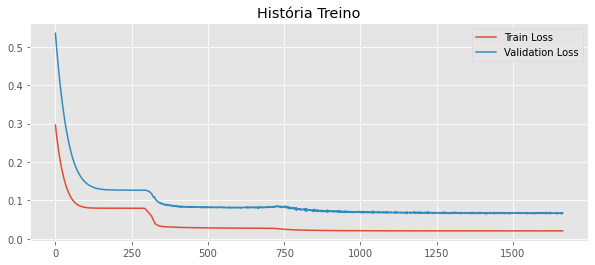

In [40]:
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = MLP1.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

In [41]:
pred_y1 = MLP1.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y1 = scalers[feature_to_predict].inverse_transform(pred_y1)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


CORRELAÇÃO (r): 0.5637861549931397 Pi (p) :8.780947005370453e-09
RMSE = 130.6207420543897
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 31013.924839019775
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -6853.758045196533
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2312.6828842163086
ERRO ABSOLUTO MEDIANO = 86.74371337890625
ERRO ABSOLUTO PERCENTUAL MEDIO = 648770.693320813%


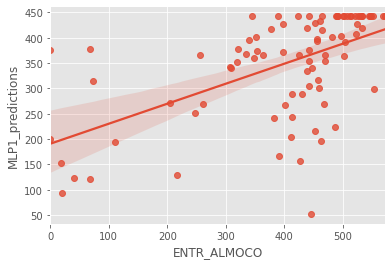

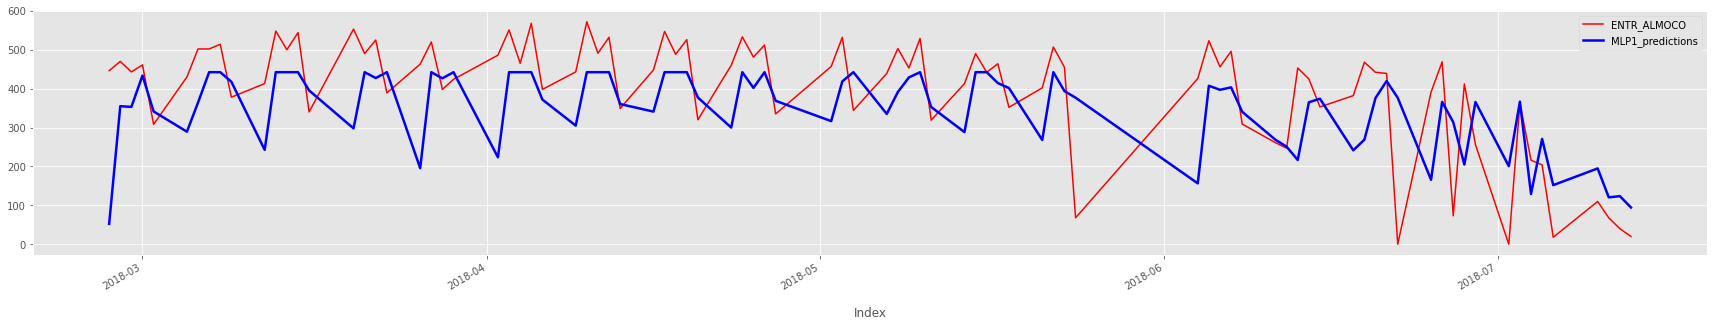

(0.5637861549931397,
 8.780947005370453e-09,
 130.6207420543897,
 648770.693320813,
 -6853.758045196533,
 2312.6828842163086)

In [42]:
import scipy
import seaborn as sns
df_val['MLP1_predictions'] = pred_y1
avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'MLP1_predictions',df_models_metrics)

In [43]:
df_models_metrics

,parameters,MLP1_predictions
0,TOTAL_PROJETADAS,31013.924839
1,TOTAL_CONSUMIDAS,35555.000000
2,TOTAL_SUBPROJETADAS,-6853.758045
3,TOTAL_SUPERPROJETADAS,2312.682884
4,ERRO_ABS_MEDIO,86.743713
5,ERRO_ABS_PER_MEDIO,648770.693321


In [44]:
#%%
###################### modelo MLP 2 com mais camadas
current_model = 'MLP2'
MLP2 = keras.Sequential()
MLP2.add(layers.Flatten(input_shape=(num_lags, num_features),))
MLP2.add(layers.Dense(15, activation='relu'))
MLP2.add(layers.Dense(5, activation='relu'))
MLP2.add(layers.Dense(1, activation='relu'))
MLP2.add(layers.Dense(num_output, activation='linear'))
MLP2.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(MLP2, show_shapes=True)
MLP2.save_weights(prefix + current_model + "_wheigts_initial.h5")
######################

(243, 5, 3) (243,)


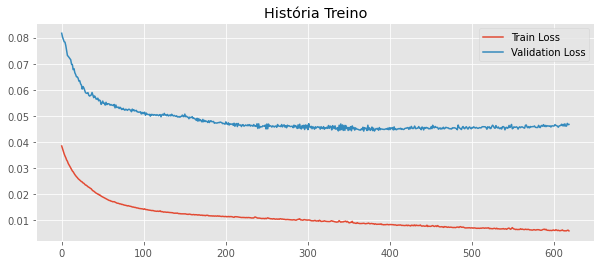

In [45]:
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = MLP2.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


CORRELAÇÃO (r): 0.6809783551246777 Pi (p) :2.091478529031948e-13
RMSE = 107.97413966672336
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 35217.926471710205
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -3433.2632026672363
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 3096.1896743774414
ERRO ABSOLUTO MEDIANO = 48.17791748046875
ERRO ABSOLUTO PERCENTUAL MEDIO = 726271.6051407185%


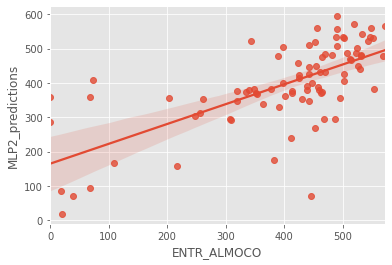

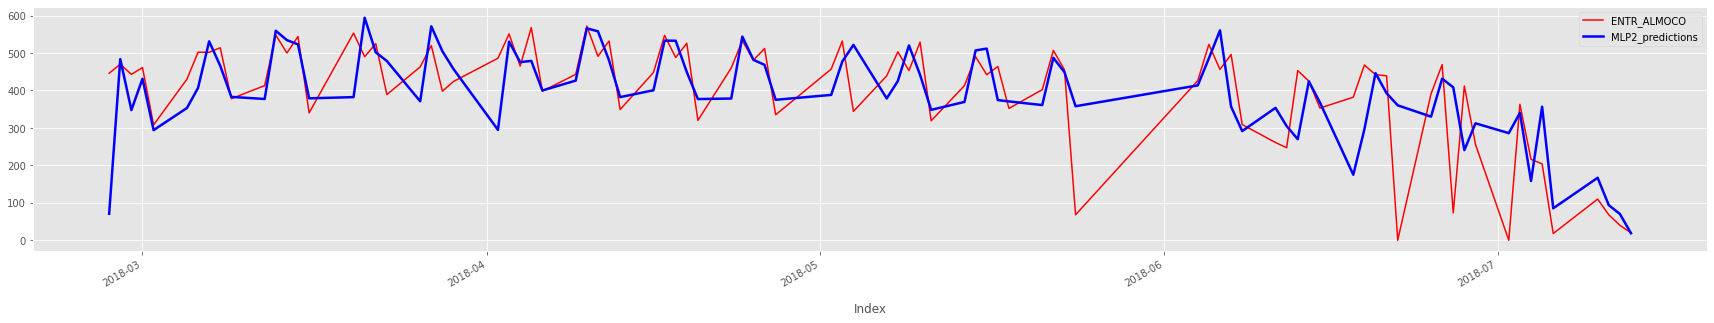

(0.6809783551246777,
 2.091478529031948e-13,
 107.97413966672336,
 726271.6051407185,
 -3433.2632026672363,
 3096.1896743774414)

In [46]:
#MLP2
pred_y2 = MLP2.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y2 = scalers[feature_to_predict].inverse_transform(pred_y2)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))

df_val['MLP2_predictions'] = pred_y2
avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'MLP2_predictions',df_models_metrics)

In [47]:
df_models_metrics

,parameters,MLP1_predictions,MLP2_predictions
0,TOTAL_PROJETADAS,31013.924839,35217.926472
1,TOTAL_CONSUMIDAS,35555.000000,35555.000000
2,TOTAL_SUBPROJETADAS,-6853.758045,-3433.263203
3,TOTAL_SUPERPROJETADAS,2312.682884,3096.189674
4,ERRO_ABS_MEDIO,86.743713,48.177917
5,ERRO_ABS_PER_MEDIO,648770.693321,726271.605141


In [48]:
MLP1.save(prefix + 'MLP1' + "_validated.h5")
MLP2.save(prefix + 'MLP2' + "_validated.h5")

## **Modelos que usam somente dados endógenos**

In [49]:
num_lags = scaled_train_x.shape[1] # ou = 5
num_features = scaled_train_x.shape[2] # ou = 3
num_output = 1 # saída é um unico numero escalar
learning_rate = 0.001 # bom valor

### RNN_ENDO_1

In [50]:
#model_rnn_unique_1
###################### modelo RNN com uma única camada 
RNN_ENDO_1 = keras.Sequential()
num_units = 16 # ajustavel
RNN_ENDO_1.add(layers.GRU(num_units, input_shape=(num_lags, num_features),))
RNN_ENDO_1.add(layers.Dense(num_output, activation='linear'))
RNN_ENDO_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(RNN_ENDO_1, show_shapes=True)
RNN_ENDO_1.save_weights(prefix + 'RNN_ENDO_1' + "_wheigts_initial.h5")
######################

### RNN_ENDO_2

In [51]:
#model_rnn_unique_2
###################### modelo RNN com mais de uma camada
RNN_ENDO_2 = keras.Sequential()
num_units = 16 # ajustavel
num_units_2 = 8 # ajustavel
num_units_3 = 4 # ajustavel
RNN_ENDO_2.add(layers.GRU(num_units, input_shape=(num_lags, num_features), return_sequences=True)) # return_sequences=True
RNN_ENDO_2.add(layers.Dropout(0.2)) # não necessário porém é bom
RNN_ENDO_2.add(layers.GRU(num_units_2, return_sequences=True))
RNN_ENDO_2.add(layers.Dropout(0.2)) # não necessário porém é bom
RNN_ENDO_2.add(layers.GRU(num_units_3, return_sequences=False)) # return_sequences=False
RNN_ENDO_2.add(layers.Dense(num_output, activation='linear'))
RNN_ENDO_2.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(RNN_ENDO_2, show_shapes=True)
RNN_ENDO_2.save_weights(prefix + 'RNN_ENDO_2' + "_wheigts_initial.h5")
######################

### MLP_ENDO_1

In [52]:
#model_mlp_unique_1
###################### modelo MLP com uma única camada
MLP_ENDO_1 = keras.Sequential()
MLP_ENDO_1.add(layers.Flatten(input_shape=(num_lags, num_features),))
MLP_ENDO_1.add(layers.Dense(64, activation='relu'))
MLP_ENDO_1.add(layers.Dense(32, activation='relu'))
MLP_ENDO_1.add(layers.Dense(num_output, activation='linear'))
MLP_ENDO_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(MLP_ENDO_1, show_shapes=True)
MLP_ENDO_1.save_weights(prefix + 'MLP_ENDO_1' + "_wheigts_initial.h5")
######################

###TREINO DOS MODELOS

###model_rnn_unique_1

(243, 5, 3) (243,)
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: case1_RNN_ENDO_1_trained/assets


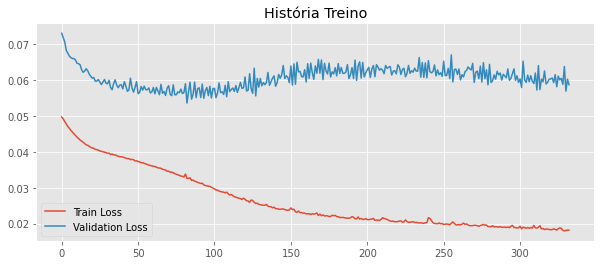

In [53]:
#RNN_ENDO_1
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = RNN_ENDO_1.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)
RNN_ENDO_1.save(prefix + 'RNN_ENDO_1' + '_trained')

###model_rnn_unique_2

(243, 5, 3) (243,)
INFO:tensorflow:Assets written to: case1_RNN_ENDO_2_trained/assets


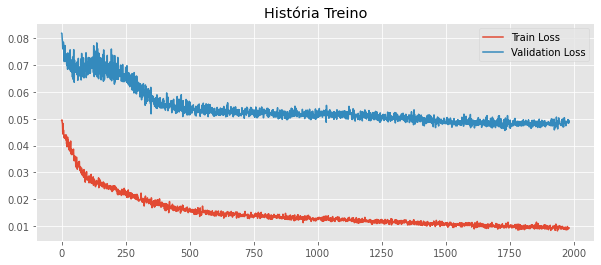

In [54]:
#################################################################################
#################################################################################
#model_rnn_unique_2
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = RNN_ENDO_2.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)
RNN_ENDO_2.save(prefix + 'RNN_ENDO_2' + '_trained')

###model_mlp_unique_1

(243, 5, 3) (243,)
INFO:tensorflow:Assets written to: case1_MLP_ENDO_1_trained/assets


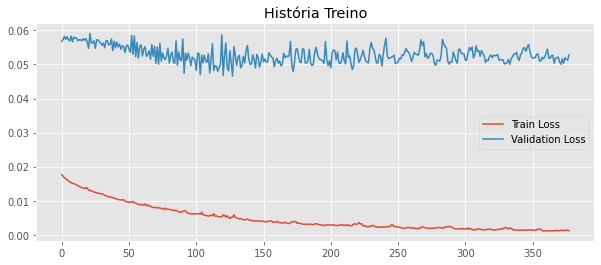

In [55]:
#################################################################################
#################################################################################
#MLP_ENDO_1
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = MLP_ENDO_1.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)
MLP_ENDO_1.save(prefix + 'MLP_ENDO_1' + '_trained')

### **AVALIAÇÂO DO MODELO**

###RNN_ENDO_1

RMSE:  118.98273426840373


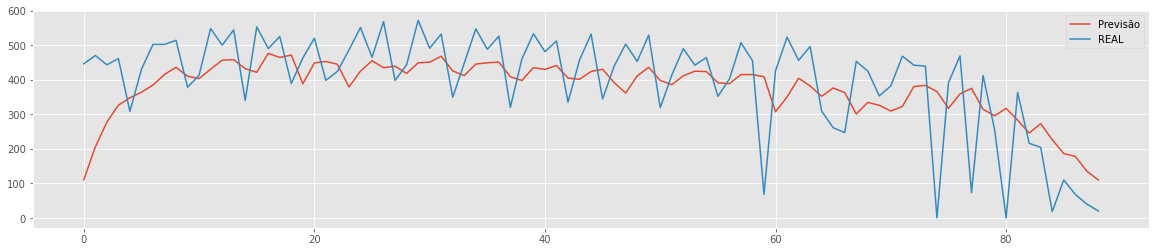

CORRELAÇÃO (r): 0.5849940682670396 Pi (p) :1.7434738379234432e-09


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RMSE = 118.98273426840373
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 33423.96739196777
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5248.0078125
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 3116.9752044677734
ERRO ABSOLUTO MEDIANO = 78.28146362304688
ERRO ABSOLUTO PERCENTUAL MEDIO = 767154.1470620014%


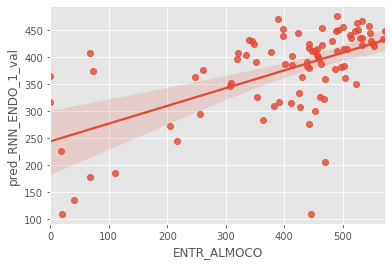

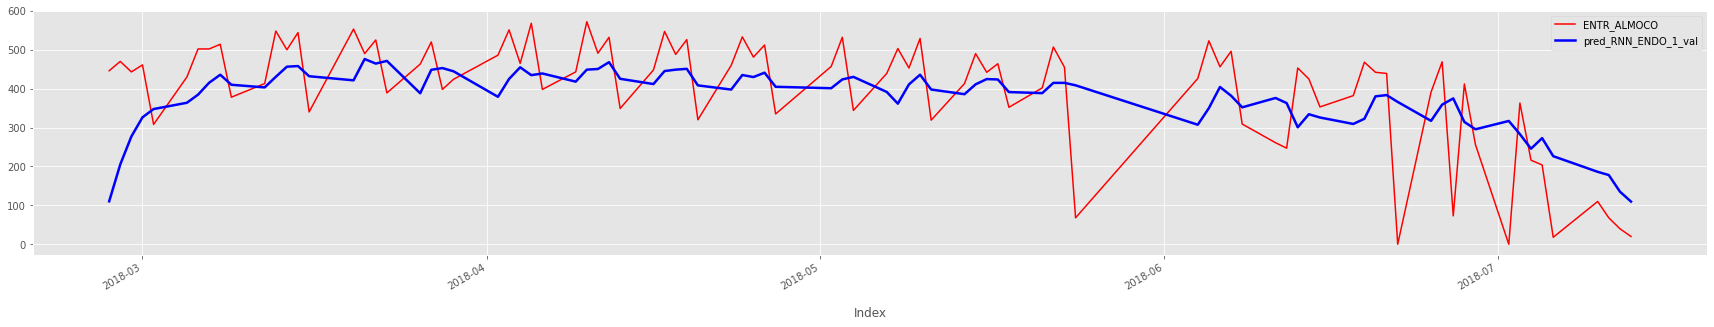

(0.5849940682670396,
 1.7434738379234432e-09,
 118.98273426840373,
 767154.1470620014,
 -5248.0078125,
 3116.9752044677734)

In [56]:
#RNN_ENDO_1
model_name = 'RNN_ENDO_1'
model = RNN_ENDO_1
pred_y = model.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

In [57]:
df_models_metrics

,parameters,MLP1_predictions,MLP2_predictions,pred_RNN_ENDO_1_val
0,TOTAL_PROJETADAS,31013.924839,35217.926472,33423.967392
1,TOTAL_CONSUMIDAS,35555.000000,35555.000000,35555.000000
2,TOTAL_SUBPROJETADAS,-6853.758045,-3433.263203,-5248.007812
3,TOTAL_SUPERPROJETADAS,2312.682884,3096.189674,3116.975204
4,ERRO_ABS_MEDIO,86.743713,48.177917,78.281464
5,ERRO_ABS_PER_MEDIO,648770.693321,726271.605141,767154.147062


###RNN_ENDO_2

RMSE:  109.81020024143946


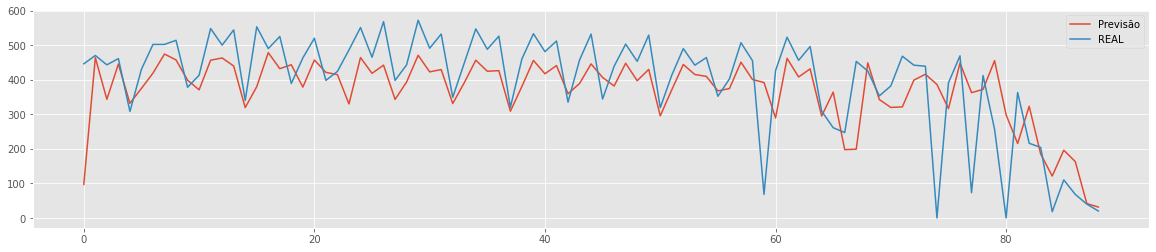

CORRELAÇÃO (r): 0.6753384458677313 Pi (p) :3.903678433027079e-13


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RMSE = 109.81020024143946
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 32984.970529556274
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -4821.583518981934
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2251.554048538208
ERRO ABSOLUTO MEDIANO = 57.326904296875
ERRO ABSOLUTO PERCENTUAL MEDIO = 768974.9938304229%


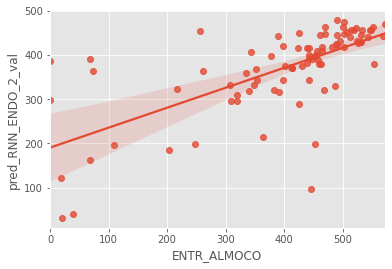

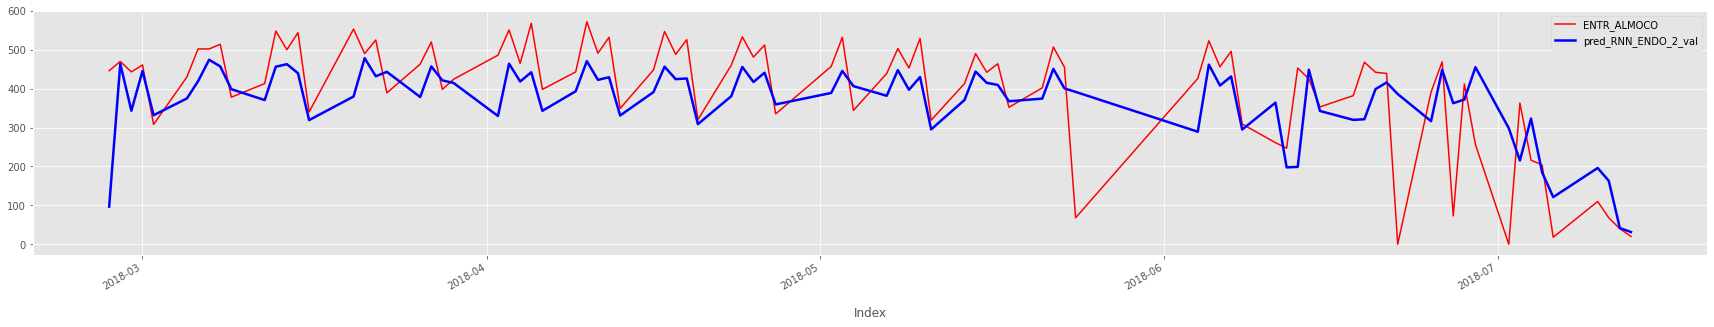

(0.6753384458677313,
 3.903678433027079e-13,
 109.81020024143946,
 768974.9938304229,
 -4821.583518981934,
 2251.554048538208)

In [58]:
#RNN_ENDO_2
model_name = 'RNN_ENDO_2'
model = RNN_ENDO_2
pred_y = model.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

###MLP_ENDO_1

RMSE:  110.92902359567118


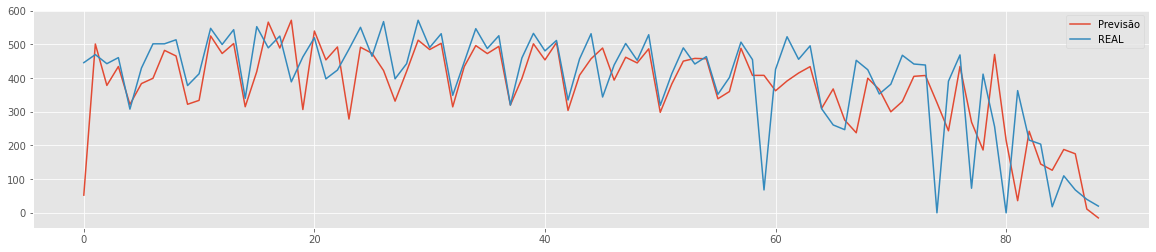

CORRELAÇÃO (r): 0.6791684214084684 Pi (p) :2.5590689588089596e-13


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RMSE = 110.92902359567118
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 33611.37430477142
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -4328.862397193909
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2385.236701965332
ERRO ABSOLUTO MEDIANO = 41.878570556640625
ERRO ABSOLUTO PERCENTUAL MEDIO = 610040.9192675158%


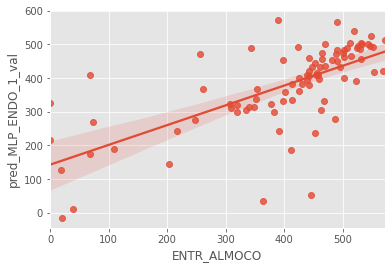

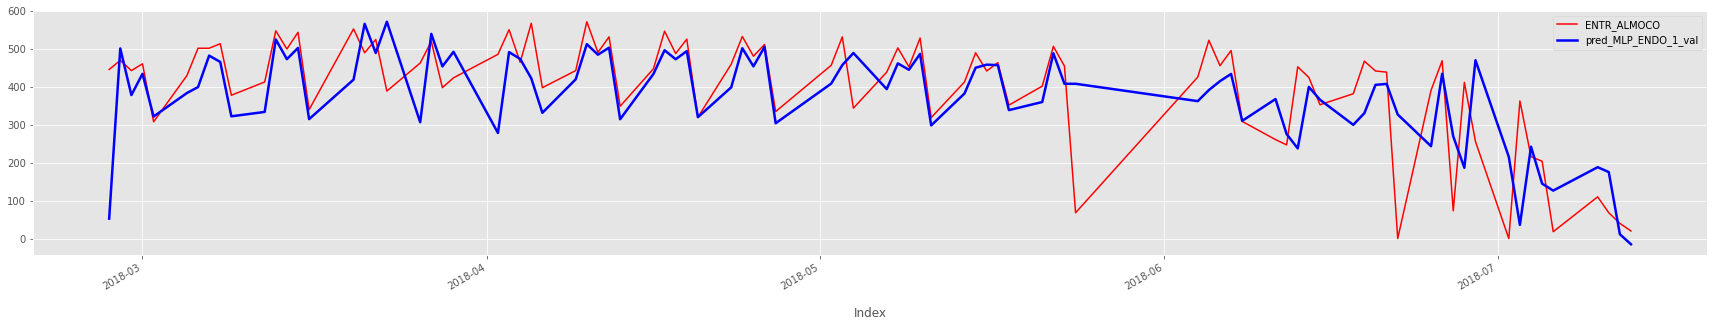

(0.6791684214084684,
 2.5590689588089596e-13,
 110.92902359567118,
 610040.9192675158,
 -4328.862397193909,
 2385.236701965332)

In [59]:
#RNN_ENDO_2
model_name = 'MLP_ENDO_1'
model = MLP_ENDO_1
pred_y = model.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

In [60]:
RNN_ENDO_1.save(prefix+'RNN_ENDO_1_validated.h5')
RNN_ENDO_2.save(prefix+'RNN_ENDO_2_validated.h5')
MLP_ENDO_1.save(prefix+'MLP_ENDO_1_validated.h5')

## **Modelos que usam dados endógenos e exógenos**

In [61]:
num_lags = scaled_train_x.shape[1] # ou = 5
num_features = scaled_train_x.shape[2] # ou = 3
num_dense_features = train_x_dense.shape[1]
num_output = 1
print('Numero de valores totais na entrada da rede:', num_lags * num_features + num_dense_features)

Numero de valores totais na entrada da rede: 25


#### **RNN_EXO_1 RNN e DENSO (multinput) - UMA CAMADA RNN E UMA DENSA**

In [63]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(32, return_sequences=False)(input_layer_recorrente)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru, layer_dense])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
RNN_EXO_1 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################
RNN_EXO_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(RNN_EXO_1, show_shapes=True)
RNN_EXO_1.save_weights(prefix + 'RNN_EXO_1' + "_wheigts_initial.h5")

#### **RNN_EXO_2 MODELO RNN e DENSO (multinput) - DUAS CAMADAS RNN e DUAS DENSAS (SEM DROPOUT)**

In [64]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(32, return_sequences=True)(input_layer_recorrente)
layer_gru_2 = layers.GRU(16, )(layer_gru)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense_2 = layers.Dense(16, activation='relu')(layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru_2, layer_dense_2])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
RNN_EXO_2 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################
RNN_EXO_2.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(RNN_EXO_2, show_shapes=True)
RNN_EXO_2.save_weights(prefix + 'RNN_EXO_2' + "_wheigts_initial.h5")

#### **RNN_EXO_3 RNN e DENSO (multinput) - DUAS CAMADAS RNN e DUAS DENSAS (COM DROPOUT)**


In [65]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(16, return_sequences=True)(input_layer_recorrente)
layer_dropout = layers.Dropout(0.2)(layer_gru)
layer_gru_2 = layers.GRU(32,)(layer_dropout)
layer_dropout_2 = layers.Dropout(0.2)(layer_gru_2)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense_2 = layers.Dense(16, activation='relu')(layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_dropout_2, layer_dense_2])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
RNN_EXO_3 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################
RNN_EXO_3.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(RNN_EXO_3, show_shapes=True)
RNN_EXO_3.save_weights(prefix + 'RNN_EXO_3' + "_wheigts_initial.h5")

#### **TREINOS MODELOS MULTINPUT**

#### **RNN_EXO_1**

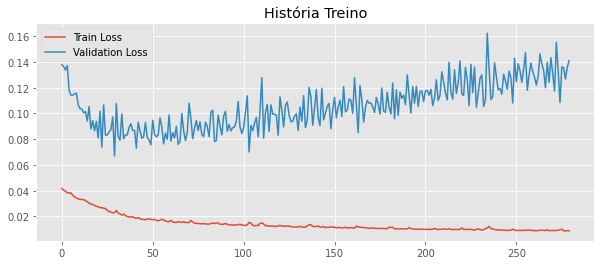

In [66]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = RNN_EXO_1.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **RNN_EXO_2**

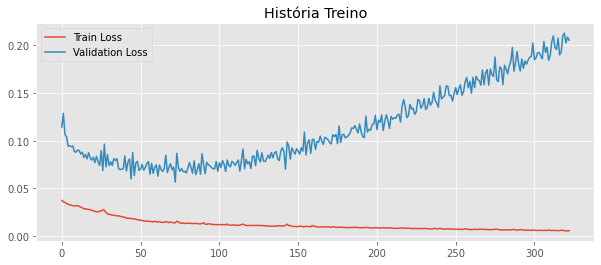

In [67]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = RNN_EXO_2.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **RNN_EXO_3**

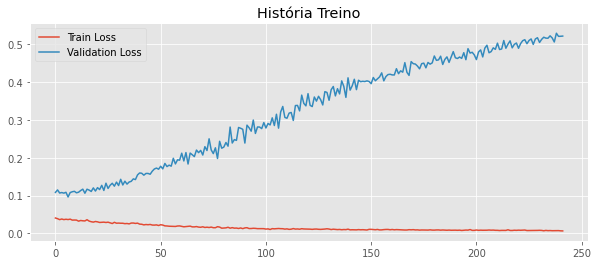

In [68]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = RNN_EXO_3.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **AVALIAÇÂO DO MODELO**

#### **RNN_EXO_1**

RMSE:  132.9496197534569
CORRELAÇÃO (r): 0.5678557313864051 Pi (p) :6.495911385408426e-09
RMSE = 132.9496197534569
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 30223.764709472656
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -7585.754409790039
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2254.5191192626953
ERRO ABSOLUTO MEDIANO = 99.81130981445312
ERRO ABSOLUTO PERCENTUAL MEDIO = 783943.4401953422%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


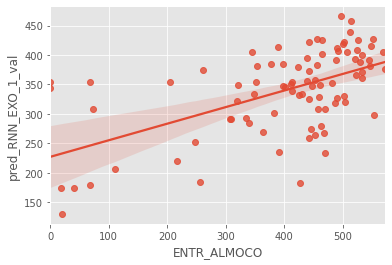

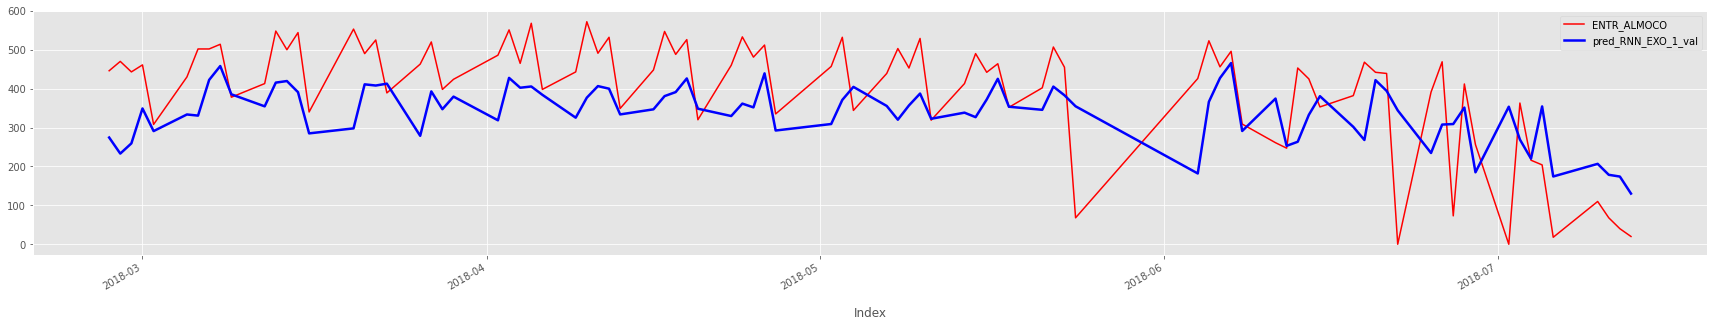

(0.5678557313864051,
 6.495911385408426e-09,
 132.9496197534569,
 783943.4401953422,
 -7585.754409790039,
 2254.5191192626953)

In [69]:
#RNN_EXO_1
model_name = 'RNN_EXO_1'
model = RNN_EXO_1
x_validation = (scaled_val_x, val_x_dense)
pred_y = model.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = df_val['ENTR_ALMOCO']
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

#### **RNN_EXO_2**

RMSE:  122.32142544582184
CORRELAÇÃO (r): 0.5881866144896996 Pi (p) :1.353050573541138e-09
RMSE = 122.32142544582184
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 32146.112915039062
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5875.795913696289
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2466.9088287353516
ERRO ABSOLUTO MEDIANO = 76.1607666015625
ERRO ABSOLUTO PERCENTUAL MEDIO = 831822.5241647426%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


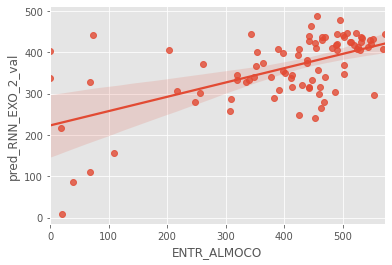

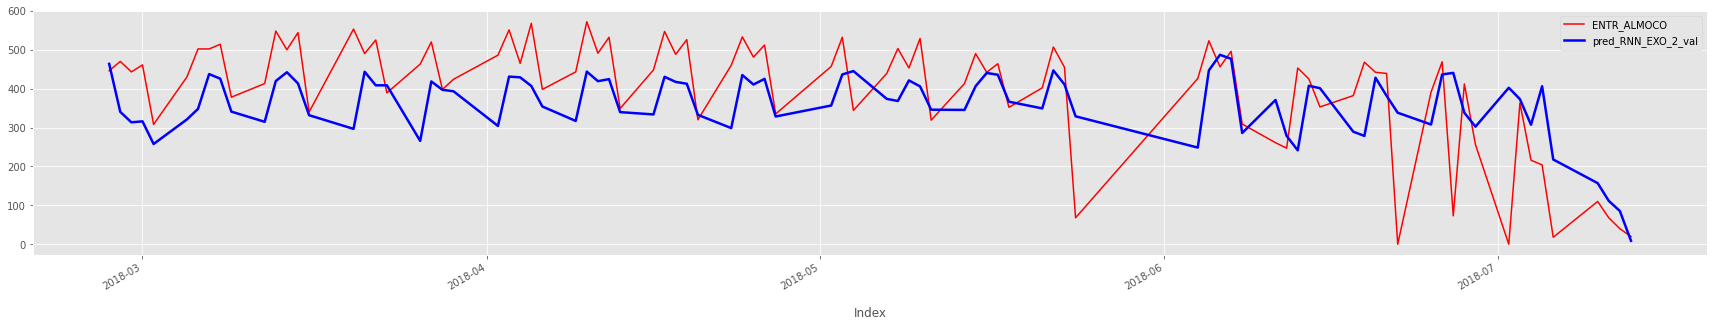

(0.5881866144896996,
 1.353050573541138e-09,
 122.32142544582184,
 831822.5241647426,
 -5875.795913696289,
 2466.9088287353516)

In [70]:
#RNN_EXO_2
model_name = 'RNN_EXO_2'
model = RNN_EXO_2
x_validation = (scaled_val_x, val_x_dense)
pred_y = model.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = df_val['ENTR_ALMOCO']
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

#### **RNN_EXO_3**

RMSE:  122.32142544582184
CORRELAÇÃO (r): 0.5881866144896996 Pi (p) :1.353050573541138e-09
RMSE = 122.32142544582184
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 32146.112915039062
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5875.795913696289
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2466.9088287353516
ERRO ABSOLUTO MEDIANO = 76.1607666015625
ERRO ABSOLUTO PERCENTUAL MEDIO = 831822.5241647426%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


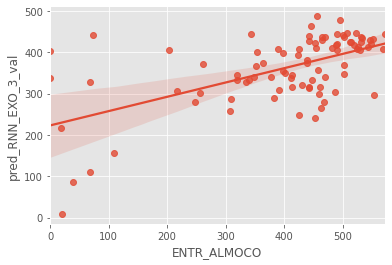

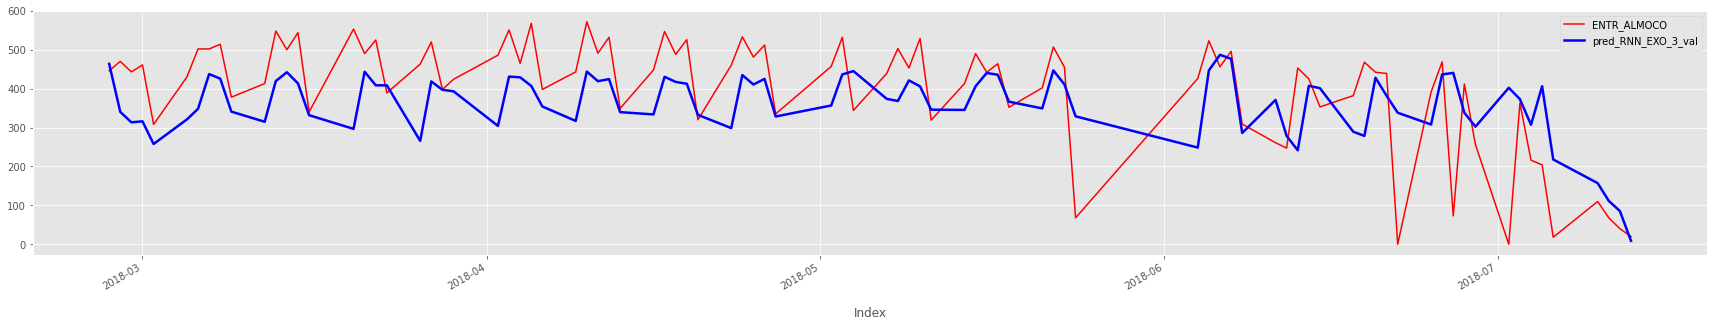

(0.5881866144896996,
 1.353050573541138e-09,
 122.32142544582184,
 831822.5241647426,
 -5875.795913696289,
 2466.9088287353516)

In [71]:
#RNN_EXO_3
model_name = 'RNN_EXO_3'
model = RNN_EXO_2
x_validation = (scaled_val_x, val_x_dense)
pred_y = model.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = df_val['ENTR_ALMOCO']
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

# RESULTADOS DAS AVALIAÇÕES


*   TOTAL PROJETADO
*   TOTAL CONSUMIDO
*   TOTAL SUBPROJETADO
*   TOTAL SUPER PROJETADO
*   ERRO ABSOLUTO MEDIO
*   ERRO PERCENTUAL MEDIO



In [72]:
df_models_metrics

,parameters,MLP1_predictions,MLP2_predictions,pred_RNN_ENDO_1_val,pred_RNN_ENDO_2_val,pred_MLP_ENDO_1_val,pred_RNN_EXO_1_val,pred_RNN_EXO_2_val,pred_RNN_EXO_3_val
0,TOTAL_PROJETADAS,31013.924839,35217.926472,33423.967392,32984.970530,33611.374305,30223.764709,32146.112915,32146.112915
1,TOTAL_CONSUMIDAS,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000
2,TOTAL_SUBPROJETADAS,-6853.758045,-3433.263203,-5248.007812,-4821.583519,-4328.862397,-7585.754410,-5875.795914,-5875.795914
3,TOTAL_SUPERPROJETADAS,2312.682884,3096.189674,3116.975204,2251.554049,2385.236702,2254.519119,2466.908829,2466.908829
4,ERRO_ABS_MEDIO,86.743713,48.177917,78.281464,57.326904,41.878571,99.811310,76.160767,76.160767
5,ERRO_ABS_PER_MEDIO,648770.693321,726271.605141,767154.147062,768974.993830,610040.919268,783943.440195,831822.524165,831822.524165


In [73]:
RNN_EXO_1.save(prefix + 'RNN_EXO_1_validated.h5')
RNN_EXO_2.save(prefix + 'RNN_EXO_2_validated.h5')
RNN_EXO_3.save(prefix + 'RNN_EXO_3_validated.h5')

# REDEFINIÇÃO / TREINO E REAVALIAÇÃO DO rnn_unique_1

In [74]:
#RNN_ENDO_1_NEW
###################### modelo RNN com uma única camada 
RNN_ENDO_1_NEW = keras.Sequential()
num_units = 25 # ajustavel
RNN_ENDO_1_NEW.add(layers.GRU(num_units, input_shape=(num_lags, num_features),))
RNN_ENDO_1_NEW.add(layers.Dense(num_output, activation='linear'))
RNN_ENDO_1_NEW.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(RNN_ENDO_1_NEW, show_shapes=True)
RNN_ENDO_1_NEW.save_weights(prefix + 'RNN_ENDO_1_NEW' + "_wheigts_initial.h5")
######################

(243, 5, 3) (243,)


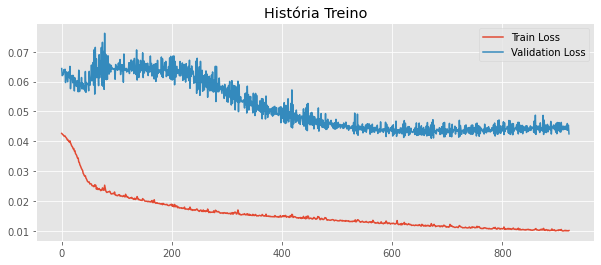

In [75]:
#RNN_ENDO_1_NEW
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = RNN_ENDO_1_NEW.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


CORRELAÇÃO (r): 0.5849940682670396 Pi (p) :1.7434738379234432e-09
RMSE = 118.98273426840373
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 33423.96739196777
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5248.0078125
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 3116.9752044677734
ERRO ABSOLUTO MEDIANO = 78.28146362304688
ERRO ABSOLUTO PERCENTUAL MEDIO = 767154.1470620014%


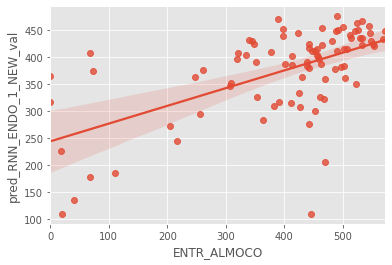

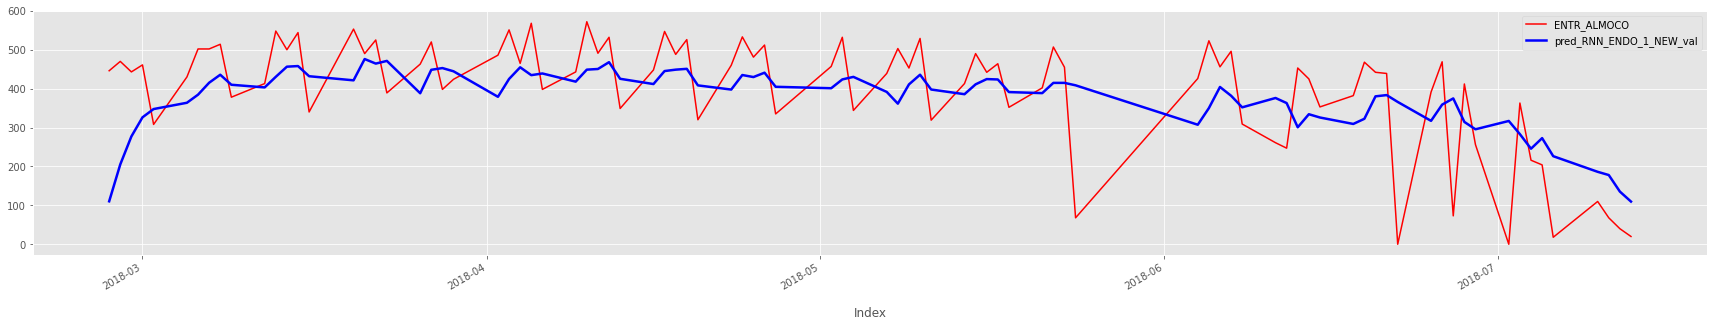

(0.5849940682670396,
 1.7434738379234432e-09,
 118.98273426840373,
 767154.1470620014,
 -5248.0078125,
 3116.9752044677734)

In [76]:
#RNN_ENDO_1_NEW
model_name = 'RNN_ENDO_1_NEW'
model = RNN_ENDO_1
pred_y = model.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)

reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

# REDEFINIÇÃO / TREINO E REAVALIAÇÃO DO multiinput_model_1

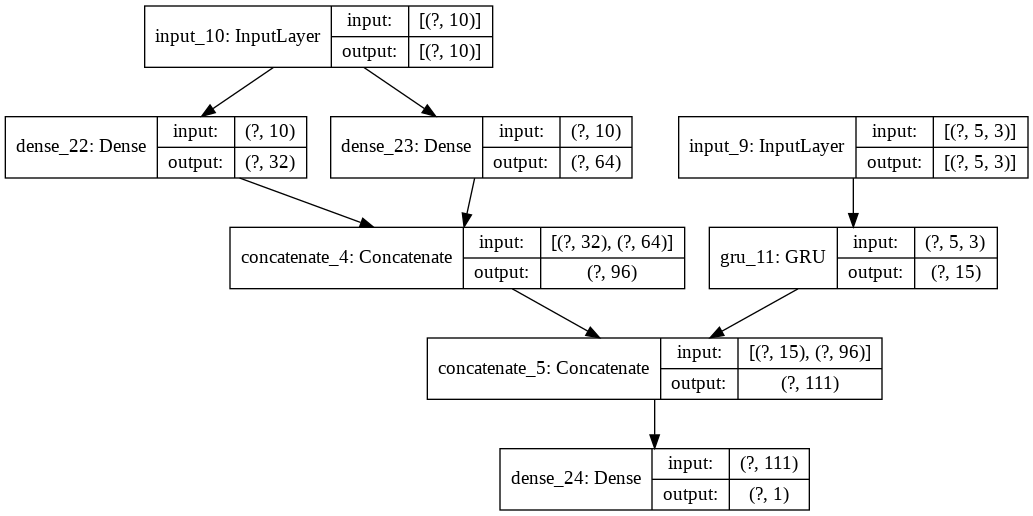

In [77]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(15, return_sequences=False)(input_layer_recorrente)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense1 = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense2 = layers.Dense(64, activation='relu')(input_layer_dense)
layer_dense = layers.concatenate([layer_dense1, layer_dense2])
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru , layer_dense])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
RNN_EXO_1_NEW = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################

RNN_EXO_1_NEW.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(RNN_EXO_1_NEW, show_shapes=True)

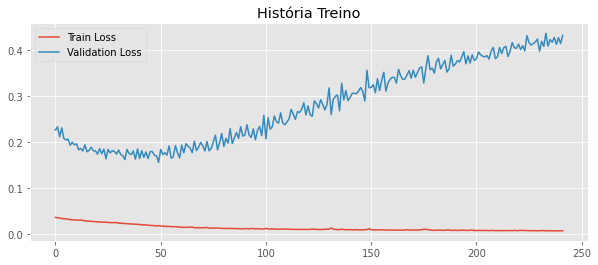

In [78]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = RNN_EXO_1_NEW.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


CORRELAÇÃO (r): 0.23053841540341008 Pi (p) :0.029741374765233256
RMSE = 195.57497214586436
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 23382.01187133789
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -14157.108993530273
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 1984.120864868164
ERRO ABSOLUTO MEDIANO = 189.70150756835938
ERRO ABSOLUTO PERCENTUAL MEDIO = 613705.1704488309%


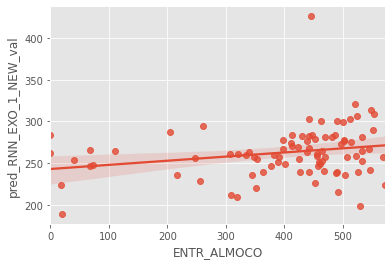

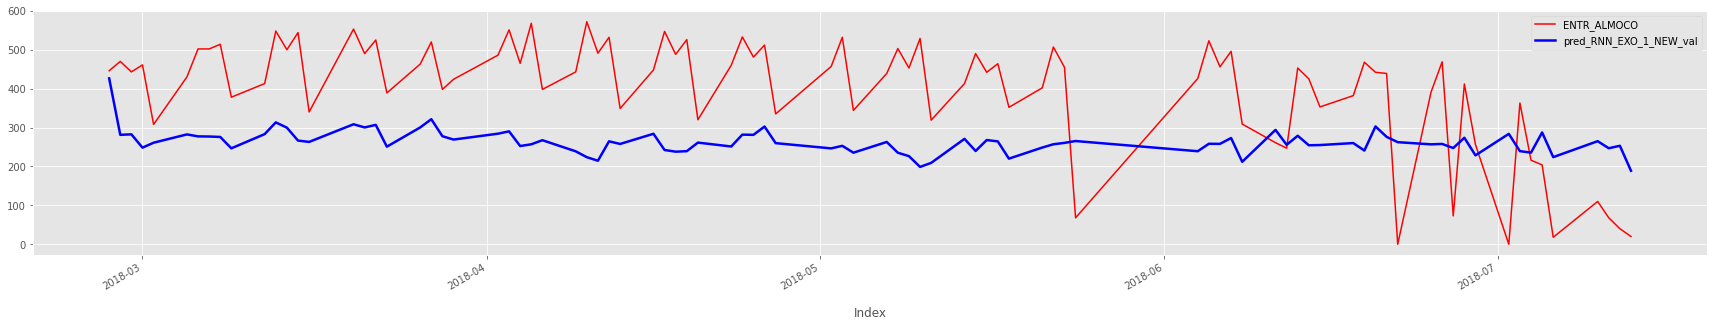

(0.23053841540341008,
 0.029741374765233256,
 195.57497214586436,
 613705.1704488309,
 -14157.108993530273,
 1984.120864868164)

In [83]:
model_name = 'RNN_EXO_1_NEW'
x_validation = (scaled_val_x, val_x_dense)
pred_y = RNN_EXO_1_NEW.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = df_val['ENTR_ALMOCO']
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

In [84]:
df_models_metrics

,parameters,MLP1_predictions,MLP2_predictions,pred_RNN_ENDO_1_val,pred_RNN_ENDO_2_val,pred_MLP_ENDO_1_val,pred_RNN_EXO_1_val,pred_RNN_EXO_2_val,pred_RNN_EXO_3_val,pred_RNN_ENDO_1_NEW_val,pred_RNN_EXO_1_NEW_val
0,TOTAL_PROJETADAS,31013.924839,35217.926472,33423.967392,32984.970530,33611.374305,30223.764709,32146.112915,32146.112915,33423.967392,23382.011871
1,TOTAL_CONSUMIDAS,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000
2,TOTAL_SUBPROJETADAS,-6853.758045,-3433.263203,-5248.007812,-4821.583519,-4328.862397,-7585.754410,-5875.795914,-5875.795914,-5248.007812,-14157.108994
3,TOTAL_SUPERPROJETADAS,2312.682884,3096.189674,3116.975204,2251.554049,2385.236702,2254.519119,2466.908829,2466.908829,3116.975204,1984.120865
4,ERRO_ABS_MEDIO,86.743713,48.177917,78.281464,57.326904,41.878571,99.811310,76.160767,76.160767,78.281464,189.701508
5,ERRO_ABS_PER_MEDIO,648770.693321,726271.605141,767154.147062,768974.993830,610040.919268,783943.440195,831822.524165,831822.524165,767154.147062,613705.170449


In [85]:
RNN_ENDO_1_NEW.save(prefix + 'RNN_ENDO_1_NEW_validated.h5')

# **TESTE - FINAL**

#### **MODELOS ENDÓGENOS*
model_rnn_unique_1
model_rnn_unique_2
model_mlp_unique_2

#### MODELO REDEFINIDO

RMSE:  114.92985962367308
CORRELAÇÃO (r): 0.5453469134009845 Pi (p) :3.927714567363418e-08
RMSE = 114.92985962367308
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 32340.145835876465
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -3412.095115661621
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 3790.240951538086
ERRO ABSOLUTO MEDIANO = 61.992218017578125
ERRO ABSOLUTO PERCENTUAL MEDIO = 84.54770173043045%


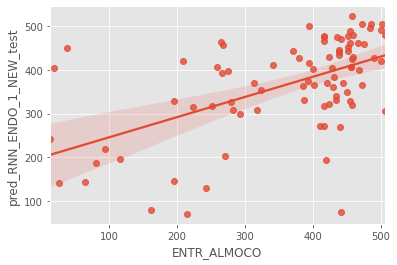

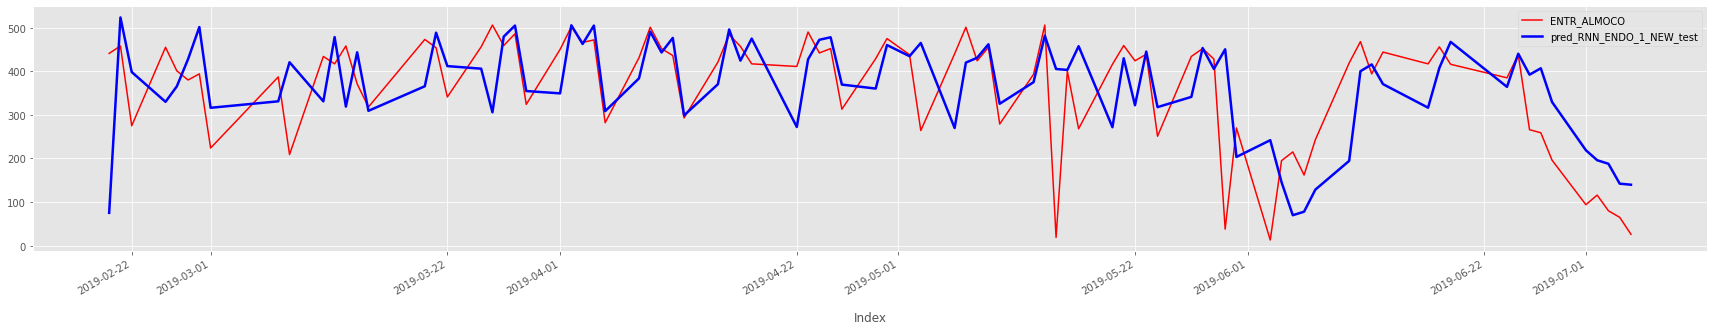

(0.5453469134009845,
 3.927714567363418e-08,
 114.92985962367308,
 84.54770173043045,
 -3412.095115661621,
 3790.240951538086)

In [86]:
#RNN_ENDO_1
model_name = 'RNN_ENDO_1_NEW'
model = RNN_ENDO_1_NEW
x_test = scaled_test_x
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)

# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))

reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

#### **RNN_ENDO_1**

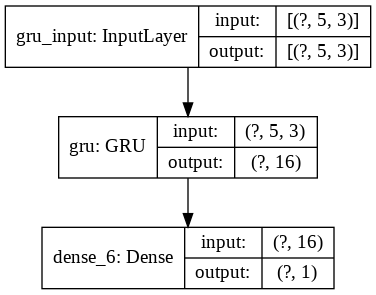

In [87]:
keras.utils.plot_model(RNN_ENDO_1, show_shapes=True)

RMSE:  115.59257225321687
CORRELAÇÃO (r): 0.4772742310298987 Pi (p) :2.581527554562312e-06
RMSE = 115.59257225321687
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 30926.620056152344
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -4315.918830871582
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 3280.538887023926
ERRO ABSOLUTO MEDIANO = 74.01921081542969
ERRO ABSOLUTO PERCENTUAL MEDIO = 87.49505795101616%


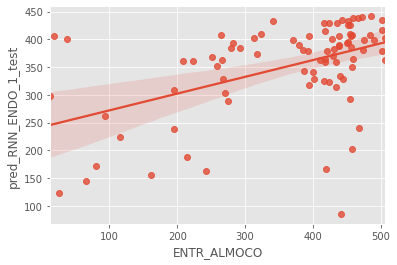

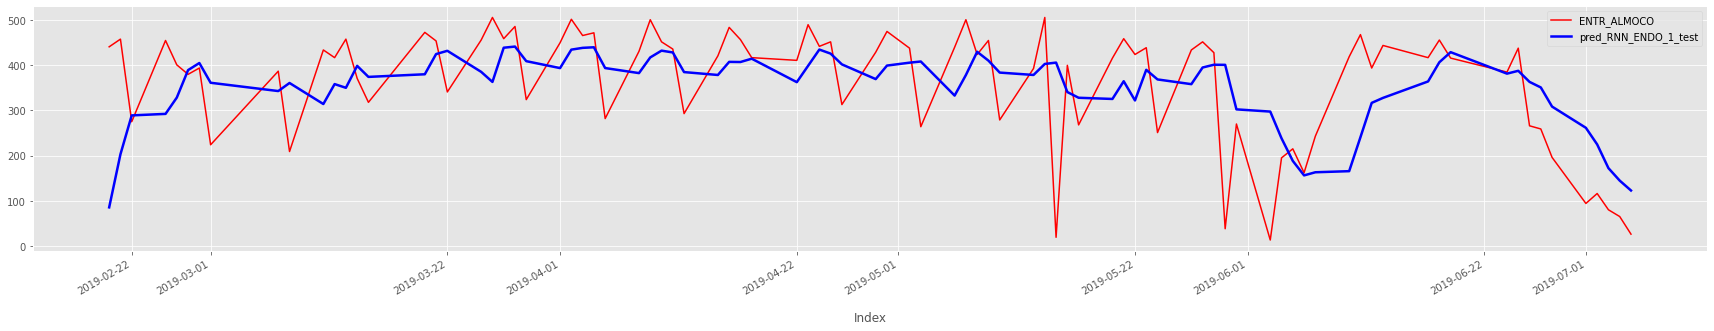

(0.4772742310298987,
 2.581527554562312e-06,
 115.59257225321687,
 87.49505795101616,
 -4315.918830871582,
 3280.538887023926)

In [88]:
#RNN_ENDO_1
model_name = 'RNN_ENDO_1'
model = RNN_ENDO_1
x_test = scaled_test_x
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)

# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))

reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

CORRELAÇÃO (r): 0.4772742310298987 Pi (p) :2.581527554562312e-06
RMSE = 115.59257225321687
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 30926.620056152344
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -4315.918830871582
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 3280.538887023926
ERRO ABSOLUTO MEDIANO = 74.01921081542969
ERRO ABSOLUTO PERCENTUAL MEDIO = 87.49505795101616%


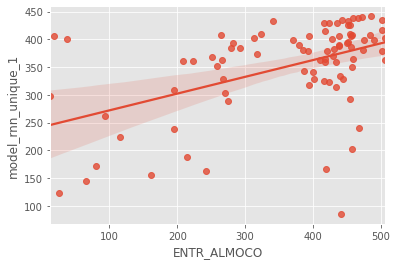

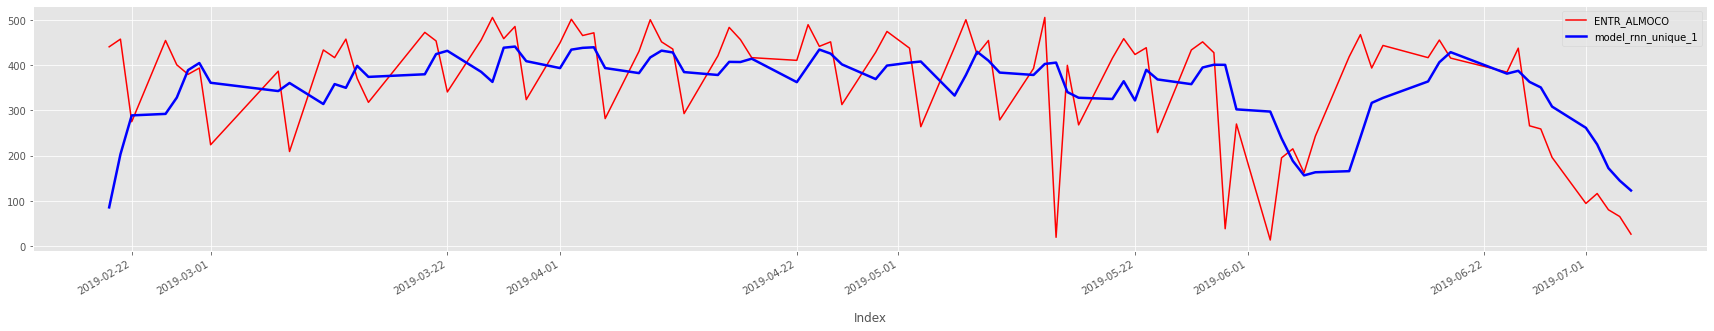

(0.4772742310298987,
 2.581527554562312e-06,
 115.59257225321687,
 87.49505795101616,
 -4315.918830871582,
 3280.538887023926)

In [89]:
df_test['model_rnn_unique_1'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'model_rnn_unique_1',df_models_metrics)

#### **RNN_ENDO_2**

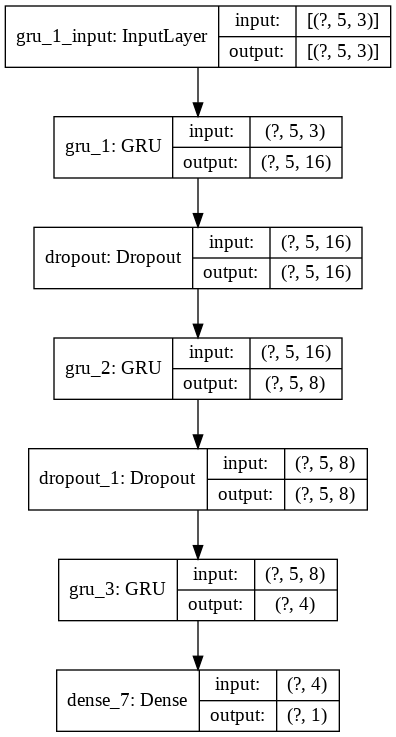

In [90]:
keras.utils.plot_model(RNN_ENDO_2, show_shapes=True)

RMSE:  108.0662937716224
CORRELAÇÃO (r): 0.595439952619013 Pi (p) :9.422107922632693e-10
RMSE = 108.0662937716224
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 31465.61107826233
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -3478.9568843841553
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2982.5679626464844
ERRO ABSOLUTO MEDIANO = 46.70722198486328
ERRO ABSOLUTO PERCENTUAL MEDIO = 74.93232120725092%


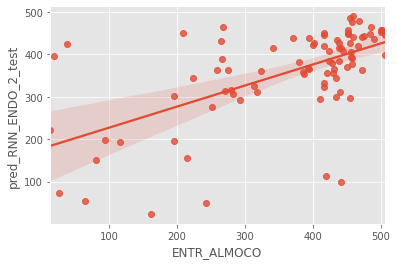

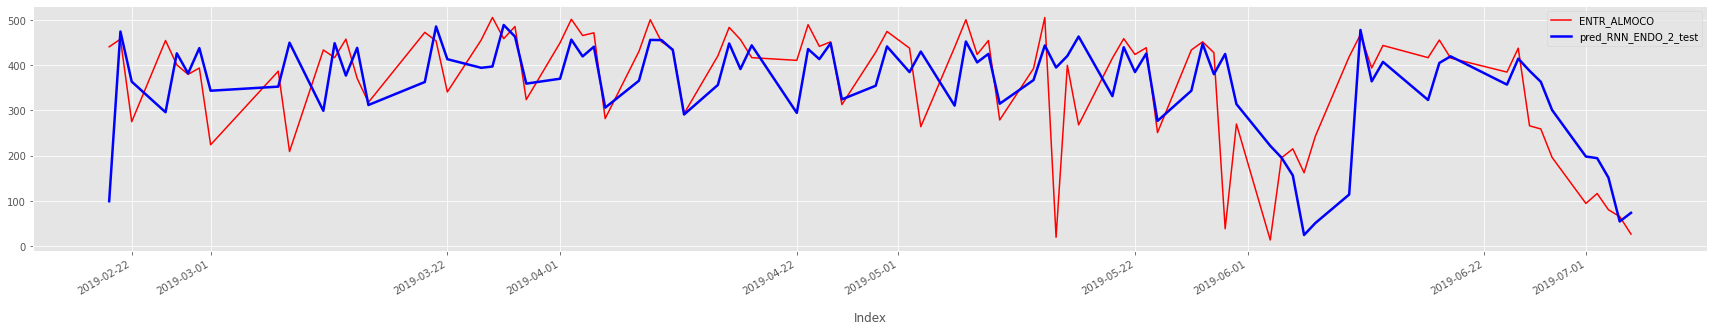

(0.595439952619013,
 9.422107922632693e-10,
 108.0662937716224,
 74.93232120725092,
 -3478.9568843841553,
 2982.5679626464844)

In [91]:
#RNN_ENDO_2
model_name = 'RNN_ENDO_2'
model = RNN_ENDO_2
x_test = scaled_test_x
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)

# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))

reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

#### **MLP_ENDO_1**

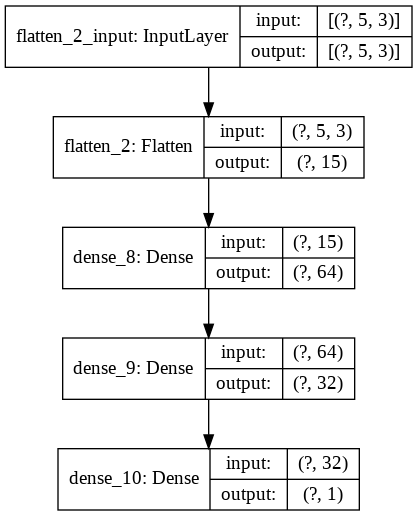

In [92]:
keras.utils.plot_model(MLP_ENDO_1, show_shapes=True)

RMSE:  128.05415989336365
CORRELAÇÃO (r): 0.5212411595055804 Pi (p) :1.9211578801789243e-07
RMSE = 128.05415989336365
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 32369.655303955078
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -3897.856979370117
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 4305.512283325195
ERRO ABSOLUTO MEDIANO = 71.89505004882812
ERRO ABSOLUTO PERCENTUAL MEDIO = 92.57770653202563%


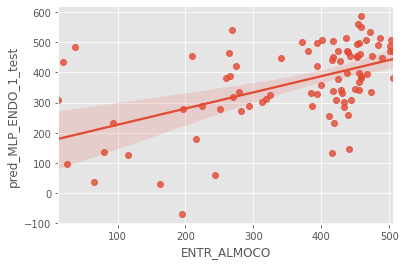

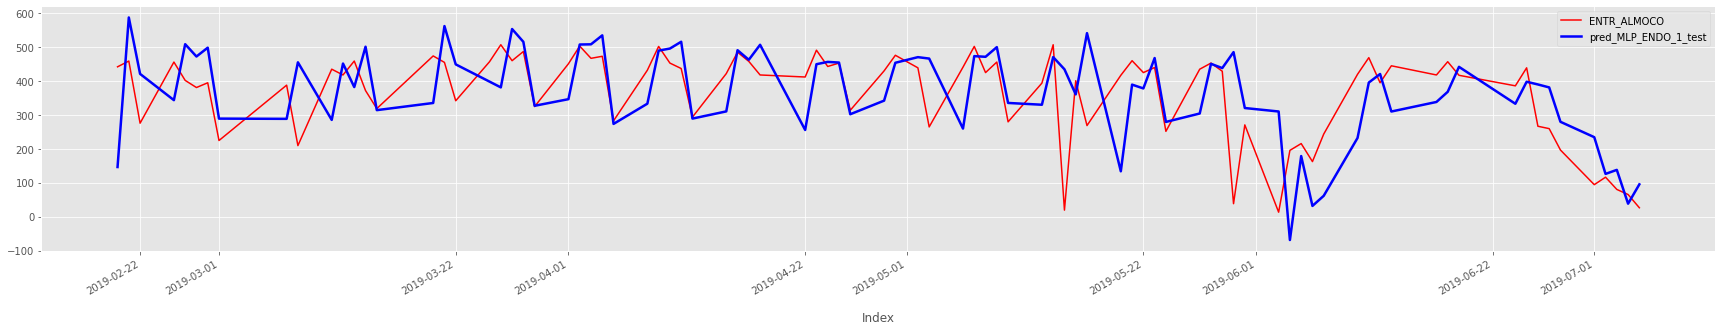

(0.5212411595055804,
 1.9211578801789243e-07,
 128.05415989336365,
 92.57770653202563,
 -3897.856979370117,
 4305.512283325195)

In [93]:
#MLP_ENDO_1
model_name = 'MLP_ENDO_1'
model = MLP_ENDO_1
x_test = scaled_test_x
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)

# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))

reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

#### **MULTI INPUT MODELS**
multiinput_model_1
multiinput_model_2
multiinput_model_3

#### **RNN_EXO_1**

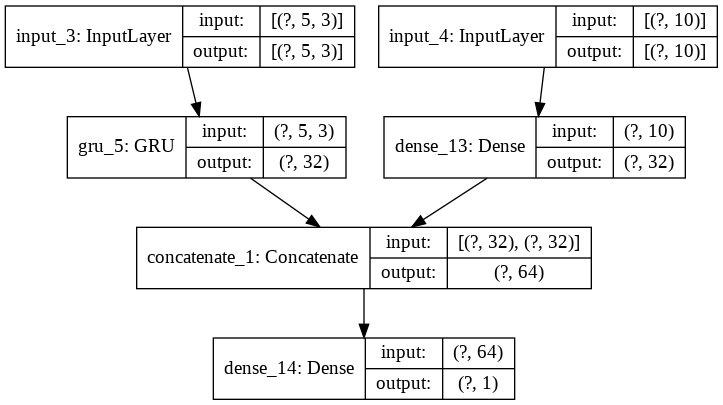

In [94]:
keras.utils.plot_model(RNN_EXO_1, show_shapes=True)

RMSE:  124.49076120428357
CORRELAÇÃO (r): 0.4122158648305426 Pi (p) :6.590759241636991e-05
RMSE = 124.49076120428357
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 28728.816802978516
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5942.356475830078
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2709.1732788085938
ERRO ABSOLUTO MEDIANO = 85.59107971191406
ERRO ABSOLUTO PERCENTUAL MEDIO = 90.98316009369515%


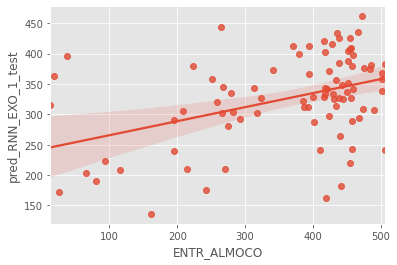

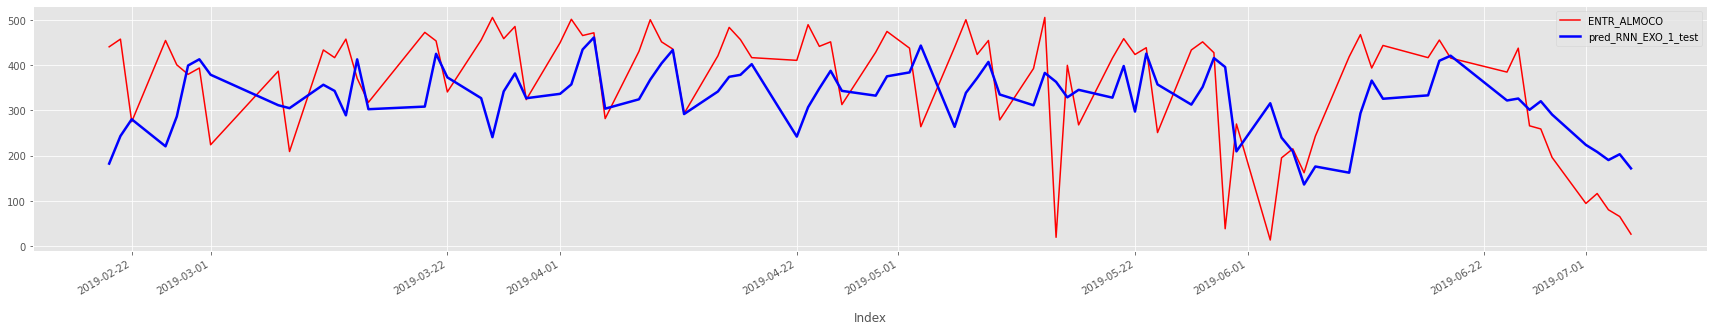

(0.4122158648305426,
 6.590759241636991e-05,
 124.49076120428357,
 90.98316009369515,
 -5942.356475830078,
 2709.1732788085938)

In [95]:
#RNN_EXO_1
model_name = 'RNN_EXO_1'
model = RNN_EXO_1
x_test = (scaled_test_x, test_x_dense)
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

#### **RNN_EXO_2**

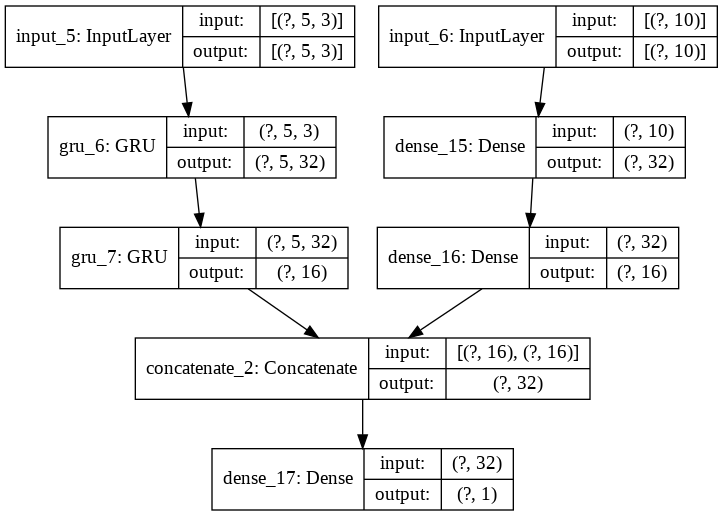

In [96]:
keras.utils.plot_model(RNN_EXO_2, show_shapes=True)

RMSE:  112.99211377165491
CORRELAÇÃO (r): 0.5206433612135913 Pi (p) :1.9952084202515358e-07
RMSE = 112.99211377165491
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 30823.149324417114
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -4183.734128952026
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 3044.8834533691406
ERRO ABSOLUTO MEDIANO = 63.59894561767578
ERRO ABSOLUTO PERCENTUAL MEDIO = 88.26479898567892%


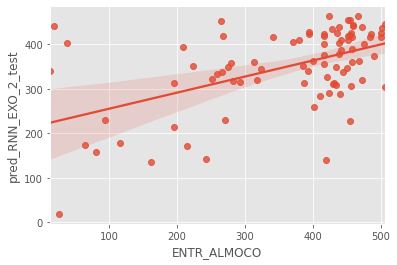

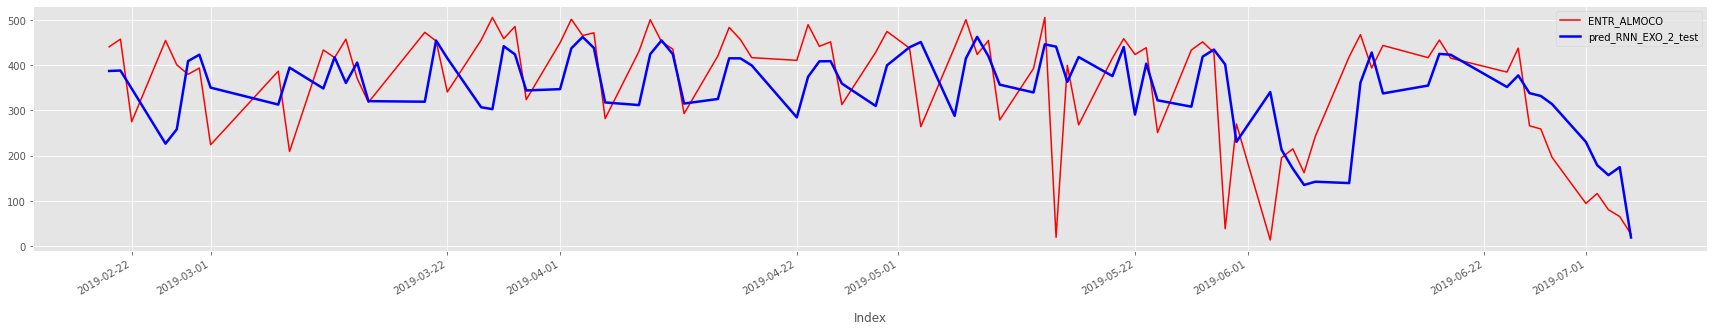

(0.5206433612135913,
 1.9952084202515358e-07,
 112.99211377165491,
 88.26479898567892,
 -4183.734128952026,
 3044.8834533691406)

In [97]:
#RNN_EXO_2
model_name = 'RNN_EXO_2'
model = RNN_EXO_2
x_test = (scaled_test_x, test_x_dense)
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

#### **RNN_EXO_3**

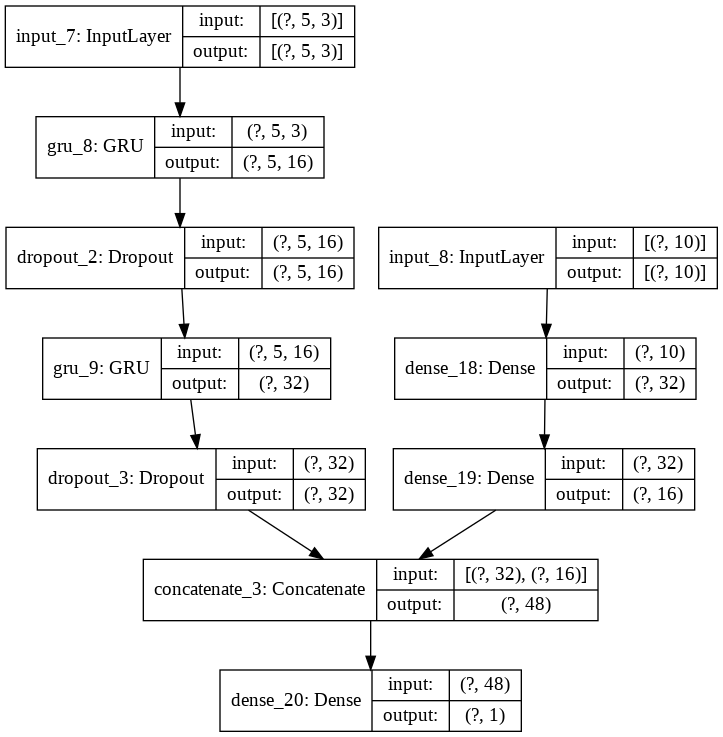

In [98]:
keras.utils.plot_model(RNN_EXO_3, show_shapes=True)

RMSE:  124.65810037942255
CORRELAÇÃO (r): 0.33963283016931 Pi (p) :0.001206736085994718
RMSE = 124.65810037942255
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 29425.79150390625
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5953.868759155273
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 3417.6602630615234
ERRO ABSOLUTO MEDIANO = 100.44429016113281
ERRO ABSOLUTO PERCENTUAL MEDIO = 98.7866482855524%


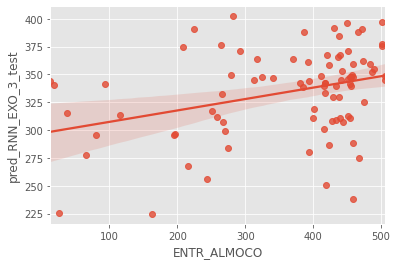

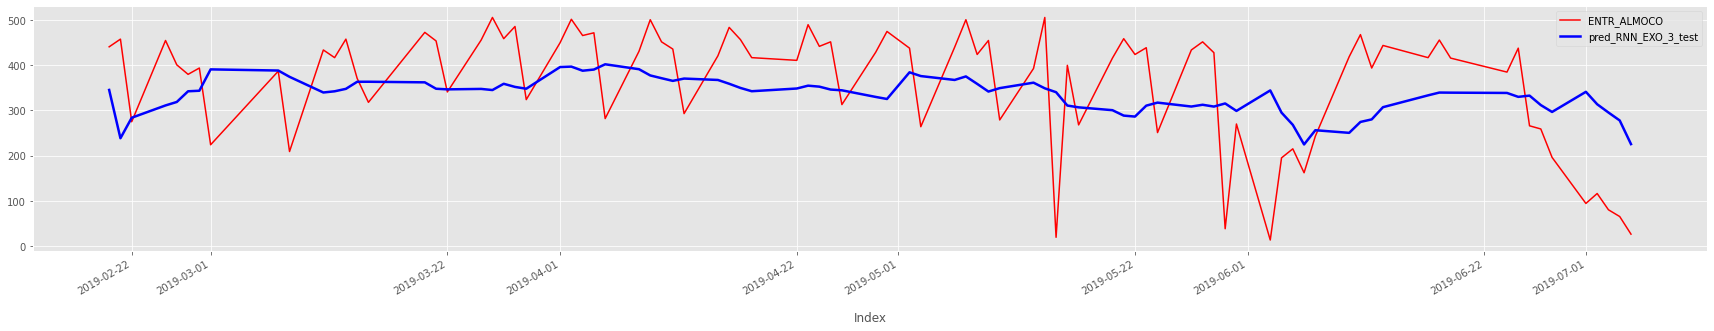

(0.33963283016931,
 0.001206736085994718,
 124.65810037942255,
 98.7866482855524,
 -5953.868759155273,
 3417.6602630615234)

In [99]:
#RNN_EXO_3
model_name = 'RNN_EXO_3'
model = RNN_EXO_3
x_test = (scaled_test_x, test_x_dense)
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

In [100]:
df_models_metrics

,parameters,MLP1_predictions,MLP2_predictions,pred_RNN_ENDO_1_val,pred_RNN_ENDO_2_val,pred_MLP_ENDO_1_val,pred_RNN_EXO_1_val,pred_RNN_EXO_2_val,pred_RNN_EXO_3_val,pred_RNN_ENDO_1_NEW_val,pred_RNN_EXO_1_NEW_val,pred_RNN_ENDO_1_NEW_test,pred_RNN_ENDO_1_test,model_rnn_unique_1,pred_RNN_ENDO_2_test,pred_MLP_ENDO_1_test,pred_RNN_EXO_1_test,pred_RNN_EXO_2_test,pred_RNN_EXO_3_test
0,TOTAL_PROJETADAS,31013.924839,35217.926472,33423.967392,32984.970530,33611.374305,30223.764709,32146.112915,32146.112915,33423.967392,23382.011871,32340.145836,30926.620056,30926.620056,31465.611078,32369.655304,28728.816803,30823.149324,29425.791504
1,TOTAL_CONSUMIDAS,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,35555.000000,31962.000000,31962.000000,31962.000000,31962.000000,31962.000000,31962.000000,31962.000000,31962.000000
2,TOTAL_SUBPROJETADAS,-6853.758045,-3433.263203,-5248.007812,-4821.583519,-4328.862397,-7585.754410,-5875.795914,-5875.795914,-5248.007812,-14157.108994,-3412.095116,-4315.918831,-4315.918831,-3478.956884,-3897.856979,-5942.356476,-4183.734129,-5953.868759
3,TOTAL_SUPERPROJETADAS,2312.682884,3096.189674,3116.975204,2251.554049,2385.236702,2254.519119,2466.908829,2466.908829,3116.975204,1984.120865,3790.240952,3280.538887,3280.538887,2982.567963,4305.512283,2709.173279,3044.883453,3417.660263
4,ERRO_ABS_MEDIO,86.743713,48.177917,78.281464,57.326904,41.878571,99.811310,76.160767,76.160767,78.281464,189.701508,61.992218,74.019211,74.019211,46.707222,71.895050,85.591080,63.598946,100.444290
5,ERRO_ABS_PER_MEDIO,648770.693321,726271.605141,767154.147062,768974.993830,610040.919268,783943.440195,831822.524165,831822.524165,767154.147062,613705.170449,84.547702,87.495058,87.495058,74.932321,92.577707,90.983160,88.264799,98.786648


# EXPORTANDO SCALERS, RESULTADOS E DATAFRAMES

In [101]:
# EXPORTAÇÃO DOS SCALERS, DATAFRAMES NORMALIZADOS E DATAFRAMES ESCALADOS
# Lib para exportar scalers, JOBLIB
# para carregar -> #scaler_numpont = load('scaler_numpont.joblib')

# Exportando scaler treinando das features numericas não temporais
path = prefix+'scaler_numpont.joblib'
dump(scaler_numpont, path)

path = prefix+'rnn_scalers_arr.joblib'
# Exportando mapa <String,Scaler> de scalers treinados das features recorrentes
dump(scalers, path)

# EXPORTANDO DATAFRAMES TO PICKLE
# PARAMETROS DO PRE-PROCESSAMENTO
preprocessamento_parameters = pd.DataFrame()
preprocessamento_parameters['periodo_de_treino'] = ["df[ : "+validation_start+"]", "["+validation_start+":"+test_start+"].loc[ "+validation_semester+" == 0]"]
preprocessamento_parameters['periodo_de_validacao'] = ["df["+validation_start+":"+test_start+"].loc[ "+validation_semester+" == 1]",""] # ,"" -> adicionando linha dummy para o dataframe não ficar esparso.
preprocessamento_parameters['periodo_de_test'] = ["df[ "+test_start+" : ]",""]
preprocessamento_parameters['features_categoricas'] = [features_categoricas,""]
preprocessamento_parameters['features_numericas_pontuais'] = [features_numericas_pontuais,""]
preprocessamento_parameters['features_temporais'] = [features_temporais,""]
preprocessamento_parameters['feature_to_predict'] = [feature_to_predict,""]

preprocessamento_parameters.to_pickle(prefix+"preprocessamento_parameters.pkl")

df_train.to_pickle(prefix+"df_train.pkl")
df_val.to_pickle(prefix+"df_val.pkl")
df_test.to_pickle(prefix+"df_test.pkl")

df_models_metrics.to_pickle(prefix+'df_models_metrics.pkl')

#%%

# Exportando NUMPY ARRAYS usando biblioteca h5py (DATAFRAMES USAM PICKLE, METODO PROPRIO DO PANDAS)
path = prefix+'np_data.h5'
hf = h5py.File(path, 'w')

#%%

# Dados Recorrentes, escalados
hf.create_dataset('scaled_train_x', data = scaled_train_x)

hf.create_dataset('scaled_val_x', data = scaled_val_x)

hf.create_dataset('scaled_test_x', data = scaled_test_x)


# Dados Categóricos (dias da semana e semestre já escalados no df original)
# concatenados com Dados Pontuais (climáticos) escalados
hf.create_dataset('train_x_dense', data = train_x_dense)

hf.create_dataset('val_x_dense', data = val_x_dense)

hf.create_dataset('test_x_dense', data = test_x_dense)

# Valores de supervisão (saída) de cada dataframe, escalados
hf.create_dataset('scaled_train_y', data = scaled_train_y)

hf.create_dataset('scaled_val_y', data = scaled_val_y)

hf.create_dataset('scaled_test_y', data = scaled_test_y)

#%%

# GRAVANDO E LIBERANDO O ARQUIVO
hf.close()

In [102]:
df_test

,SEMESTRE_1,SEMESTRE_2,SEGUNDA,TERCA,QUARTA,QUINTA,SEXTA,DISTANCIA_DIA_ANTERIOR,DISTANCIA_DIA_POSTERIOR,PERC_CONCLUSAO_SEM,PERC_CONCLUSAO_MES,PRESSAO_ATMOSFERICA,TEMPERATURA,UMIDADE,VENTO,VENDAS_ALMOCO,VENDAS_ALMOCO_1,VENDAS_ALMOCO_2,VENDAS_ALMOCO_3,VENDAS_ALMOCO_4,VENDAS_ALMOCO_5,ENTR_ALMOCO,ENTR_ALMOCO_1,ENTR_ALMOCO_2,ENTR_ALMOCO_3,ENTR_ALMOCO_4,ENTR_ALMOCO_5,ENTR_JANTAR,ENTR_JANTAR_1,ENTR_JANTAR_2,ENTR_JANTAR_3,ENTR_JANTAR_4,ENTR_JANTAR_5,RU_ALMOCO_PRED,RU_JANTAR_PRED,pred_RNN_ENDO_1_NEW_test,pred_RNN_ENDO_1_test,model_rnn_unique_1,pred_RNN_ENDO_2_test,pred_MLP_ENDO_1_test,pred_RNN_EXO_1_test,pred_RNN_EXO_2_test,pred_RNN_EXO_3_test
DATA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-20,1,0,0,0,1,0,0,61,1,0.73,71.43,947.9,23.7,78,0.5,966,10,40,58,95,111,441,14,35,44,88,77,246,0,17,14,27,50,100,65,75.288422,85.317772,85.317772,98.984299,145.950943,182.250366,387.503998,345.411926
2019-02-21,1,0,0,0,0,1,0,1,1,1.46,75.00,949.8,22.9,84,1.5,779,966,10,40,58,95,458,441,14,35,44,88,279,246,0,17,14,27,114,35,523.388794,202.882233,202.882233,474.870453,586.287476,243.321457,388.437286,238.454773
2019-02-22,1,0,0,0,0,0,1,1,3,2.19,78.57,951.6,25.5,77,2.7,314,779,966,10,40,58,275,458,441,14,35,44,61,279,246,0,17,14,57,18,398.292175,289.051147,289.051147,363.845734,420.163635,280.444153,348.338806,283.864624
2019-02-25,1,0,1,0,0,0,0,3,1,4.38,89.29,946.4,27.6,71,0.6,807,314,779,966,10,40,455,275,458,441,14,35,196,61,279,246,0,17,45,22,329.883972,292.395569,292.395569,296.073853,342.848694,220.567719,226.436798,311.131470
2019-02-26,1,0,0,1,0,0,0,1,1,5.11,92.86,949.8,21.4,87,1.6,615,807,314,779,966,10,401,455,275,458,441,14,233,196,61,279,246,0,18,0,365.316162,328.533295,328.533295,426.545074,507.593719,286.661072,258.375458,318.834534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01,1,0,1,0,0,0,0,3,1,96.35,3.23,952.2,18.8,74,0.6,80,111,376,348,442,632,94,196,259,266,438,385,23,20,120,129,146,157,500,204,218.881180,261.537384,261.537384,197.936646,233.810928,223.693253,230.292511,341.280792
2019-07-02,1,0,0,1,0,0,0,1,1,97.08,6.45,947.6,17.3,78,1.0,113,80,111,376,348,442,116,94,196,259,266,438,35,23,20,120,129,146,569,189,196.031769,224.775909,224.775909,194.300781,125.703171,208.172302,178.844284,313.745209
2019-07-03,1,0,0,0,1,0,0,1,1,97.81,9.68,946.0,16.9,82,0.5,62,113,80,111,376,348,80,116,94,196,259,266,43,35,23,20,120,129,345,167,187.817642,172.214081,172.214081,151.184082,137.527145,190.134674,156.752350,295.456299


In [103]:
df_test = pd.read_pickle("./case1_df_test.pkl")
df_val = pd.read_pickle("./case1_df_val.pkl")
df_model_metrics = pd.read_pickle("./case1_df_models_metrics.pkl")

In [104]:
df_test.to_csv(r'case1_df_test.csv')
df_test.to_excel("case1_df_test.xlsx")

df_val.to_csv(r'case1_df_val.csv')
df_val.to_excel("case1_df_val.xlsx")

df_model_metrics.to_csv(r'case1_df_models_metrics.csv')
df_model_metrics.to_excel("case1_df_models_metrics.xlsx")

In [105]:
RNN_ENDO_2 = keras.models.load_model('case1_RNN_ENDO_2_validated.h5')
